In [1]:
#importing all the required libraries over here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

#constant needed for train-test split
TRAIN_TEST_SEED = 100

### Step 1: Reading and Understanding the Data

In [2]:
bike_raw = pd.read_csv('day.csv')
bike_raw.head()

instant    dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  1/1/2018       1   0     1        0        6           0   
1        2  2/1/2018       1   0     1        0        0           0   
2        3  3/1/2018       1   0     1        0        1           1   
3        4  4/1/2018       1   0     1        0        2           1   
4        5  5/1/2018       1   0     1        0        3           1   

   weathersit       temp     atemp      hum  windspeed  casual  registered  \
0           2  14.110847  18.18125  80.5833  10.749882     331         654   
1           2  14.902598  17.68695  69.6087  16.652113     131         670   
2           1   8.050924   9.47025  43.7273  16.636703     120        1229   
3           1   8.200000  10.60610  59.0435  10.739832     108        1454   
4           1   9.305237  11.46350  43.6957  12.522300      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600

In [3]:
#Check the shape of the raw data
bike_raw.shape

(730, 16)

In [4]:
#Check data distribution in the raw data
bike_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [5]:
#Check various statistical figures in the given raw data
bike_raw.describe()

instant      season          yr        mnth     holiday     weekday  \
count  730.000000  730.000000  730.000000  730.000000  730.000000  730.000000   
mean   365.500000    2.498630    0.500000    6.526027    0.028767    2.997260   
std    210.877136    1.110184    0.500343    3.450215    0.167266    2.006161   
min      1.000000    1.000000    0.000000    1.000000    0.000000    0.000000   
25%    183.250000    2.000000    0.000000    4.000000    0.000000    1.000000   
50%    365.500000    3.000000    0.500000    7.000000    0.000000    3.000000   
75%    547.750000    3.000000    1.000000   10.000000    0.000000    5.000000   
max    730.000000    4.000000    1.000000   12.000000    1.000000    6.000000   

       workingday  weathersit        temp       atemp         hum   windspeed  \
count  730.000000  730.000000  730.000000  730.000000  730.000000  730.000000   
mean     0.683562    1.394521   20.319259   23.726322   62.765175   12.763620   
std      0.465405    0.544807    7.506729    8.150308   14.237589    5.195841   
min      0.000000    1.000000    2.424346    3.953480    0.000000    1.500244   
25%      0.000000    1.000000   13.811885   16.889713   52.000000    9.041650   
50%      1.000000    1.000000   20.465826   24.368225   62.625000   12.125325   
75%      1.000000    2.000000   26.880615   30.445775   72.989575   15.625589   
max      1.000000    3.000000   35.328347   42.044800   97.250000   34.000021   

            casual   registered          cnt  
count   730.000000   730.000000   730.000000  
mean    849.249315  3658.757534  4508.006849  
std     686.479875  1559.758728  1936.011647  
min       2.000000    20.000000    22.000000  
25%     316.250000  2502.250000  3169.750000  
50%     717.000000  3664.500000  4548.500000  
75%    1096.500000  4783.250000  5966.000000  
max    3410.000000  6946.000000  8714.000000

### Step 2: Visualizing the data

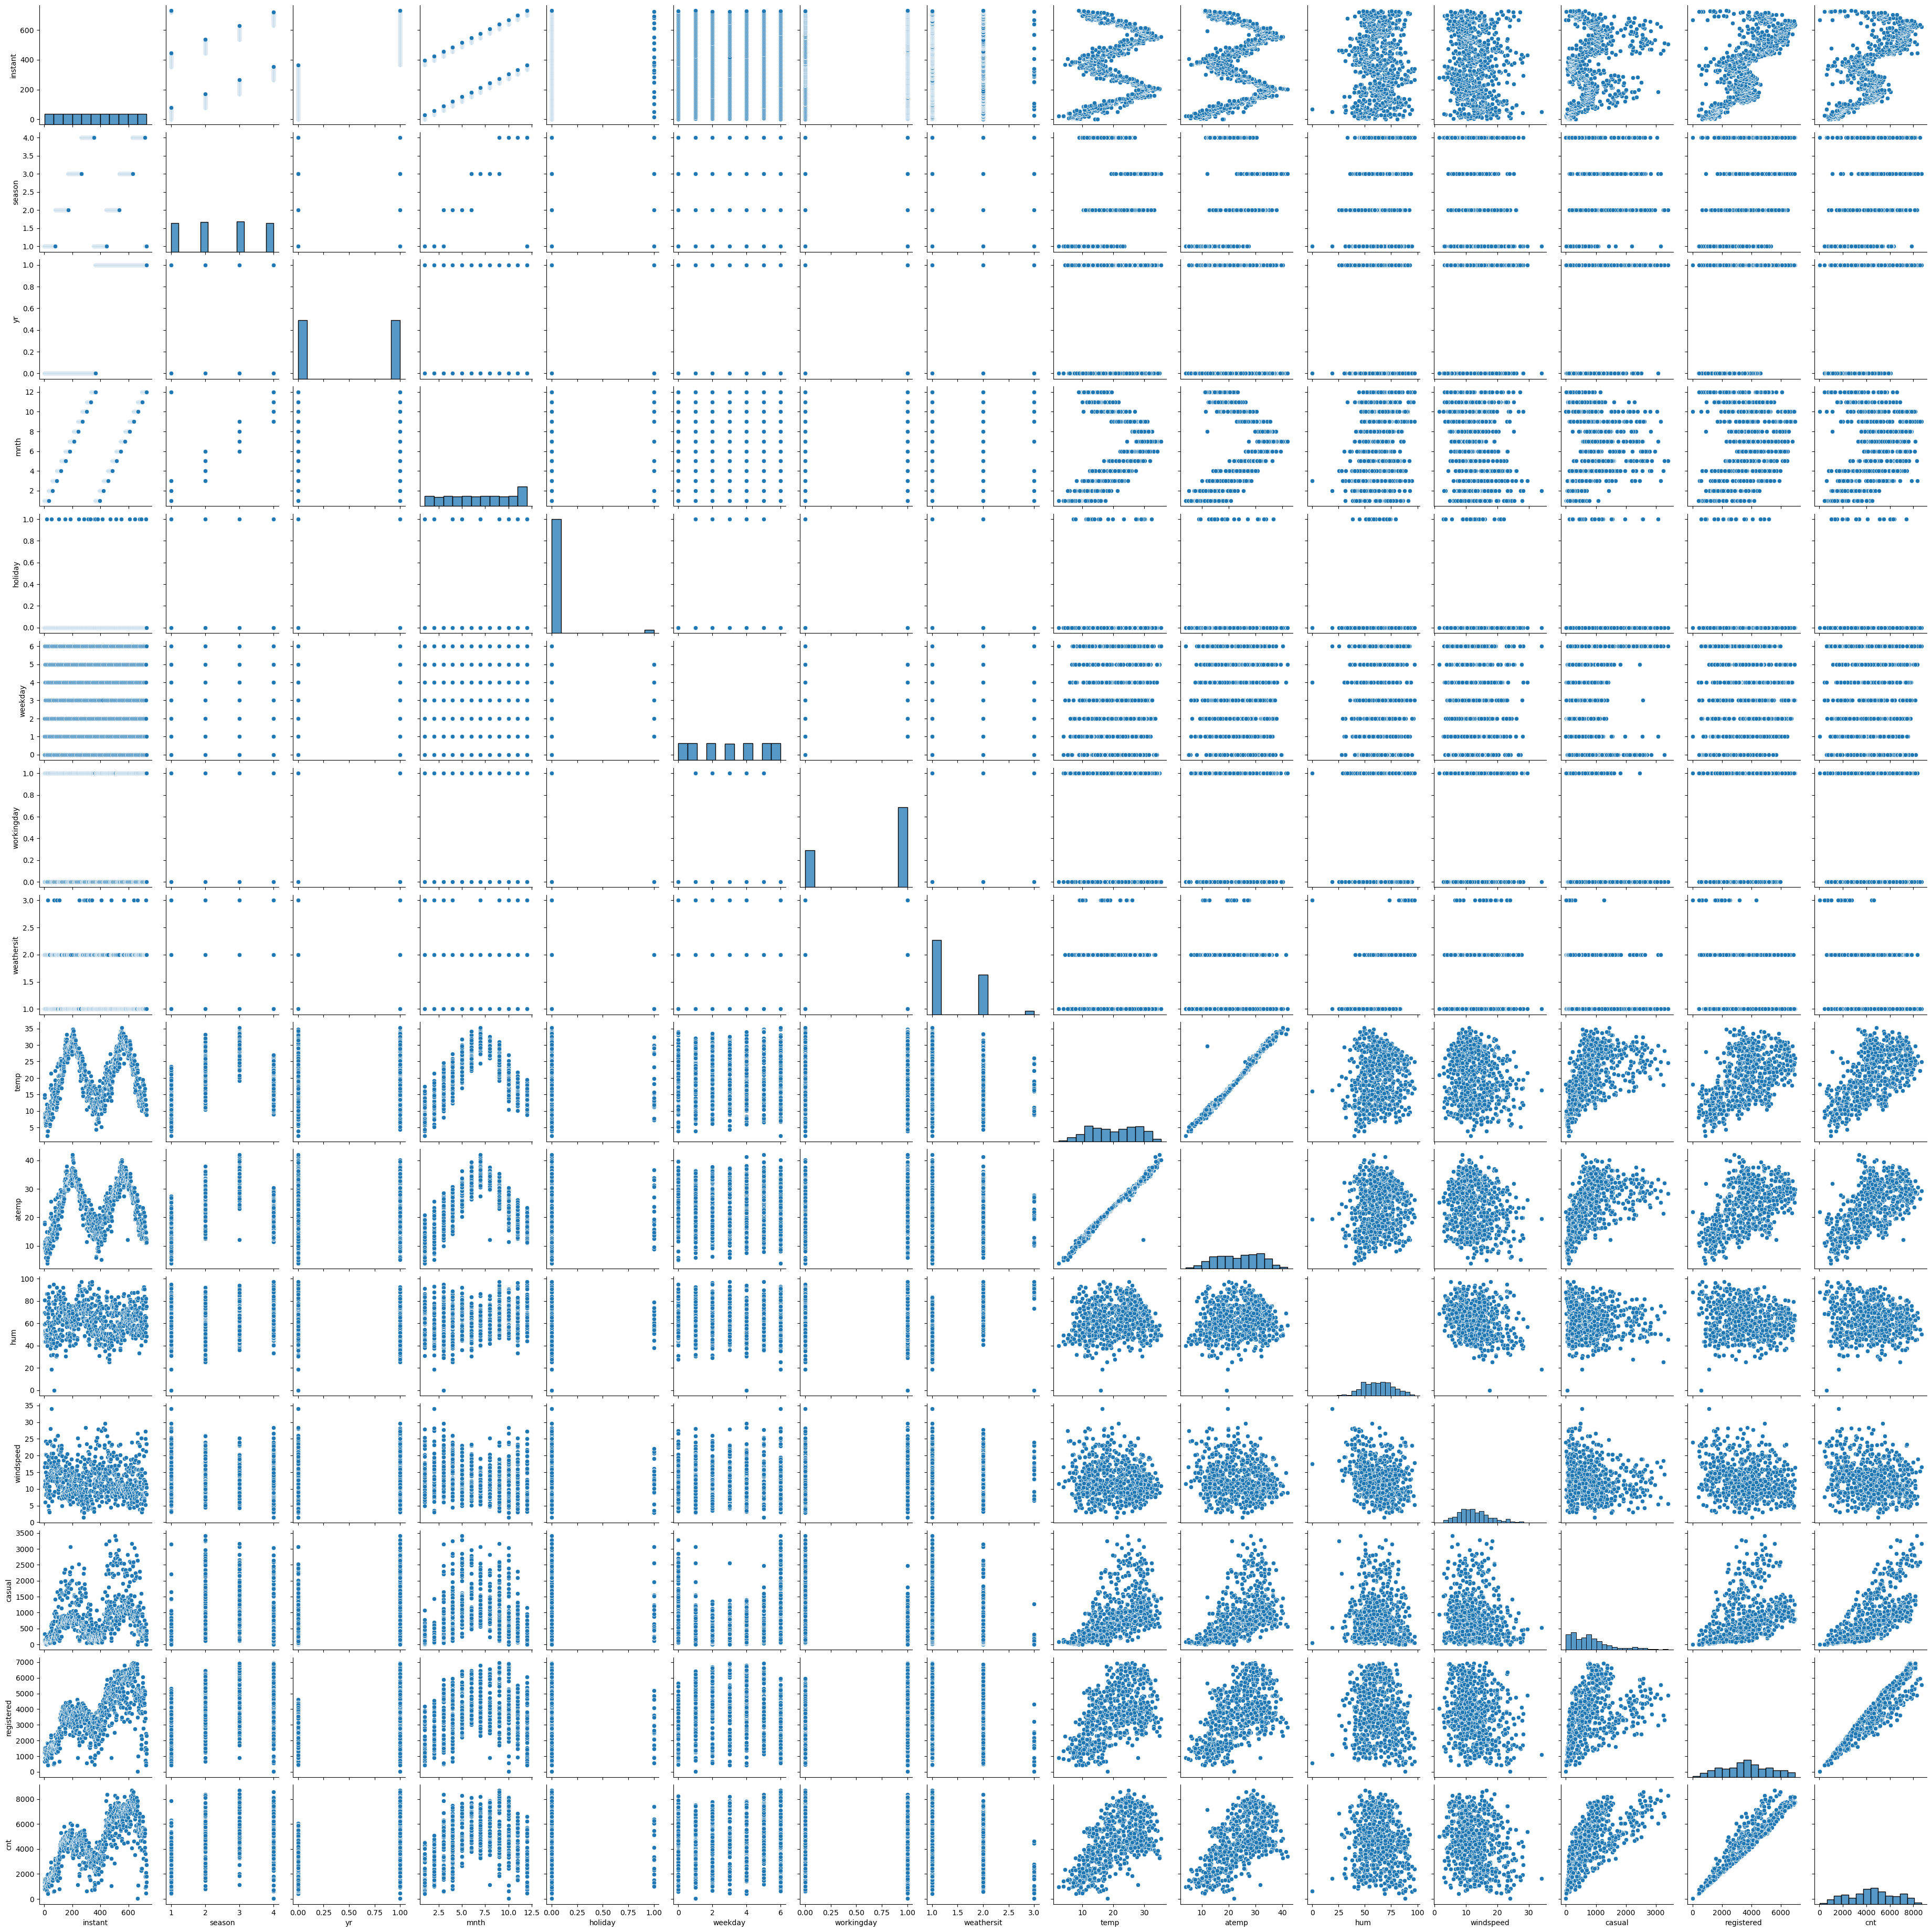

In [6]:
#Visualize the data see if there is any correlation among the variables
sns.pairplot(bike_raw)
plt.show()

#We can some correlation of count to registered, temperarture, year

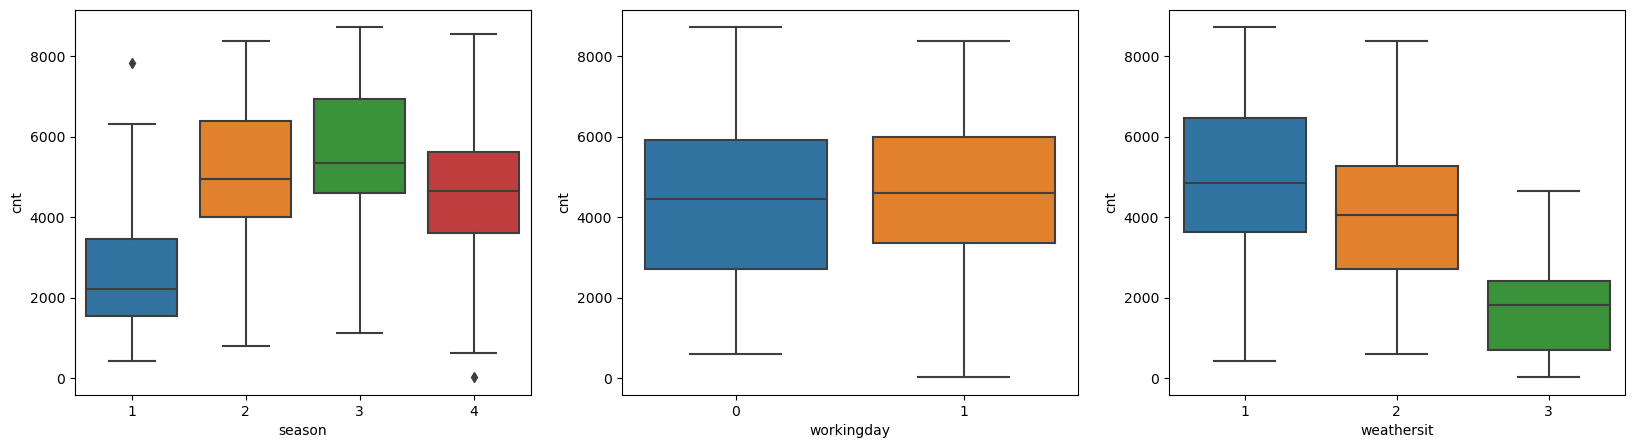

In [7]:
#We can see there are some categorical variables like season, working day, wheather situation which
#can be viewed in a box plot to understand any pattersn
plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
sns.boxplot(x = 'season', y = 'cnt', data = bike_raw)
plt.subplot(1,3,2)
sns.boxplot(x = 'workingday', y = 'cnt', data = bike_raw)
plt.subplot(1,3,3)
sns.boxplot(x = 'weathersit', y = 'cnt', data = bike_raw)
plt.show()

#We can clearly see a few patterns here:
# 1. spring season has a lower rider count
# 2. whether it s a working day or not, it doesn't make a big difference in the rider count
# 3. people prefer bikng more on a clear day, and the least on snowy days. in fact there is no bikers on rainy days

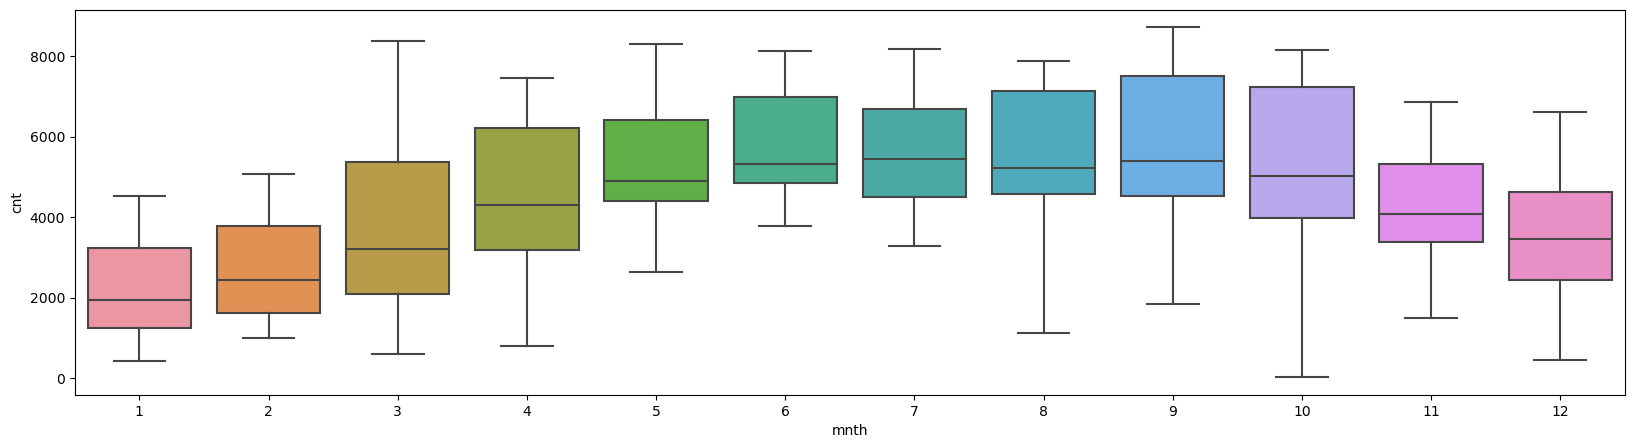

In [8]:
#Lets also check if there is any preference on the month for the bikers
plt.figure(figsize=(20, 5))
sns.boxplot(x = 'mnth', y = 'cnt', data = bike_raw)
plt.show()

#interestingly we can see a pattern where the bikers are increasing startng April and then dipping from November

### Step 3: Data Preparation 
#### There are a number of categorical variable in the dataset. We want to create dummies for those before we proceed further

In [9]:
# Season is certainly a big factor on the bike riders, hence creating dummy variables for that.
# We have 4 seasons, hence we need 3 dummy variables. Lets encode them like as follows
# Spring, Summer, Winter 
# 1       0       0     = Spring
# 0       1       0     = Summer
# 0       0       1     = Fall
# 0       0       0     = Winter

#define a function to get a text for the season
def seasonTextMap(season_code):
    if season_code == 1:
        return 'spring'
    if season_code == 2:
        return 'summer'
    if season_code == 3:
        return 'fall'
    return 'winter'

#next apply the mapping function to a new season text field
bike_raw['season_text'] = bike_raw['season'].apply(seasonTextMap)

#create dummy variables using panda library
season_data = pd.get_dummies(bike_raw['season_text'])

#dummies are created with True or False. Hence replace them with 1s ans 0s
season_data['spring'] = season_data['spring'].replace({True: 1, False: 0})
season_data['summer'] = season_data['summer'].replace({True: 1, False: 0})
season_data['winter'] = season_data['summer'].replace({True: 1, False: 0})
season_data['fall'] = season_data['fall'].replace({True: 1, False: 0})


#merge the dummies to main raw dataset 
bike_raw = pd.concat([bike_raw,season_data], axis=1)

#drop the season columns that are no longer needed
bike_raw.drop(['season','season_text','winter'], axis = 1, inplace = True)
if 'winter' in bike_raw.columns:
    bike_raw.drop['winter']

bike_raw.head()

instant    dteday  yr  mnth  holiday  weekday  workingday  weathersit  \
0        1  1/1/2018   0     1        0        6           0           2   
1        2  2/1/2018   0     1        0        0           0           2   
2        3  3/1/2018   0     1        0        1           1           1   
3        4  4/1/2018   0     1        0        2           1           1   
4        5  5/1/2018   0     1        0        3           1           1   

        temp     atemp      hum  windspeed  casual  registered   cnt  fall  \
0  14.110847  18.18125  80.5833  10.749882     331         654   985     0   
1  14.902598  17.68695  69.6087  16.652113     131         670   801     0   
2   8.050924   9.47025  43.7273  16.636703     120        1229  1349     0   
3   8.200000  10.60610  59.0435  10.739832     108        1454  1562     0   
4   9.305237  11.46350  43.6957  12.522300      82        1518  1600     0   

   spring  summer  
0       1       0  
1       1       0  
2       1       0  
3       1       0  
4       1       0

In [10]:
# Month is another big factor on the bike riders, hence creating dummy variables for that should be apt.
# Unlike seasons, we have 12 months and hence we need 11 dummy variables. Lets encode them like as follows
# jan feb  mar  apr  may  jun  jul  aug  sep  oct  nov
# 1   0    0    0    0    0    0    0    0    0    0  = Jan
# 0   1    0    0    0    0    0    0    0    0    0  = Feb 
# 0   0    1    0    0    0    0    0    0    0    0  = Mar
# 0   0    0    1    0    0    0    0    0    0    0  = Apr
# 0   0    0    0    1    0    0    0    0    0    0  = May
# 0   0    0    0    0    1    0    0    0    0    0  = Jun
# 0   0    0    0    0    0    1    0    0    0    0  = Jul
# 0   0    0    0    0    0    0    1    0    0    0  = Aug
# 0   0    0    0    0    0    0    0    1    0    0  = Sep
# 0   0    0    0    0    0    0    0    0    1    0  = Oct
# 0   0    0    0    0    0    0    0    0    0    1  = Nov
# 0   0    0    0    0    0    0    0    0    0    0  = Dec


#define a function to get a text for the month
def monthTextMap(month_code):
    months = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]
    if(month_code < 1 or month_code > 12):
        raise ValueError("Invalid month number. Please enter a number between 1 and 12.")
    
    return months[month_code-1]

#next apply the mapping function to a new month text field
bike_raw['month_text'] = bike_raw['mnth'].apply(monthTextMap)

#create dummy variables using panda library
month_data = pd.get_dummies(bike_raw['month_text'])

#dummies are created with True or False. Hence replace them with 1s ans 0s
for colName in month_data.columns:
    month_data[colName] = month_data[colName].replace({True: 1, False: 0})

#merge the dummies to main raw dataset 
bike_raw = pd.concat([bike_raw, month_data], axis=1)

#drop the month columns that are no longer needed
bike_raw.drop(['mnth','month_text','dec'], axis = 1, inplace = True)
if 'dec' in bike_raw.columns:
    bike_raw.drop['dec']

bike_raw.head()

instant    dteday  yr  holiday  weekday  workingday  weathersit       temp  \
0        1  1/1/2018   0        0        6           0           2  14.110847   
1        2  2/1/2018   0        0        0           0           2  14.902598   
2        3  3/1/2018   0        0        1           1           1   8.050924   
3        4  4/1/2018   0        0        2           1           1   8.200000   
4        5  5/1/2018   0        0        3           1           1   9.305237   

      atemp      hum  ...  aug  feb  jan  jul  jun  mar  may  nov  oct  sep  
0  18.18125  80.5833  ...    0    0    1    0    0    0    0    0    0    0  
1  17.68695  69.6087  ...    0    0    1    0    0    0    0    0    0    0  
2   9.47025  43.7273  ...    0    0    1    0    0    0    0    0    0    0  
3  10.60610  59.0435  ...    0    0    1    0    0    0    0    0    0    0  
4  11.46350  43.6957  ...    0    0    1    0    0    0    0    0    0    0  

[5 rows x 28 columns]

In [11]:
bike_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   yr          730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  casual      730 non-null    int64  
 12  registered  730 non-null    int64  
 13  cnt         730 non-null    int64  
 14  fall        730 non-null    int64  
 15  spring      730 non-null    int64  
 16  summer      730 non-null    int64  
 17  apr         730 non-null    int64  
 18  aug         730 non-null    int64  
 19  feb         730 non-null    i

In [12]:
# From the scatterplot, weather situation also seems correlated to the count of bikers. Hence created a dummy variable will be apt. 
#We have 4 weather situations, hence we need to create 3 dummies. Lets encode them like as follows
# clear misty snowy
# 1     0     0   = clear
# 0     1     0   = misty
# 0     0     1   = snowy
# 0     0     0   = rainy


def weatherSituationTextMap(weathersit_code):
    situation = ["clear", "misty", "snowy", "rainy"]
    if(weathersit_code < 1 or weathersit_code > 4):
        raise ValueError("Invalid weather situation. Please enter a number between 1 and 4.")
    return situation[weathersit_code - 1]


#next apply the mapping function to a new weather situation text field
bike_raw['weathersit_text'] = bike_raw['weathersit'].apply(weatherSituationTextMap)

#create dummy variables using panda library
weather = pd.get_dummies(bike_raw['weathersit_text'])

#dummies are created with True or False. Hence replace them with 1s ans 0s
for colName in weather.columns:
    weather[colName] = weather[colName].replace({True: 1, False: 0})

#merge the dummies to main raw dataset 
bike_raw = pd.concat([bike_raw, weather], axis=1)

#drop the weather situation columns that are no longer needed
bike_raw.drop(['weathersit','weathersit_text'], axis = 1, inplace = True)
if 'rainy' in bike_raw.columns:
    bike_raw.drop['rainy']
    
bike_raw.head()

instant    dteday  yr  holiday  weekday  workingday       temp     atemp  \
0        1  1/1/2018   0        0        6           0  14.110847  18.18125   
1        2  2/1/2018   0        0        0           0  14.902598  17.68695   
2        3  3/1/2018   0        0        1           1   8.050924   9.47025   
3        4  4/1/2018   0        0        2           1   8.200000  10.60610   
4        5  5/1/2018   0        0        3           1   9.305237  11.46350   

       hum  windspeed  ...  jul  jun  mar  may  nov  oct  sep  clear  misty  \
0  80.5833  10.749882  ...    0    0    0    0    0    0    0      0      1   
1  69.6087  16.652113  ...    0    0    0    0    0    0    0      0      1   
2  43.7273  16.636703  ...    0    0    0    0    0    0    0      1      0   
3  59.0435  10.739832  ...    0    0    0    0    0    0    0      1      0   
4  43.6957  12.522300  ...    0    0    0    0    0    0    0      1      0   

   snowy  
0      0  
1      0  
2      0  
3      0  
4      0  

[5 rows x 30 columns]

### Step 3: Splitting the Data into Training and Testing Sets
#### Next we will sprint the train and test data

In [13]:
# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(TRAIN_TEST_SEED)
bike_train, bike_test = train_test_split(bike_raw, train_size = 0.7, test_size = 0.3, random_state = TRAIN_TEST_SEED)

In [14]:
#we have 730 records - check if the distribution of train and test is correct
bike_train.shape

(510, 30)

In [15]:
#checking test data set
bike_test.shape

(219, 30)

In [16]:
bike_train.head()

instant      dteday  yr  holiday  weekday  workingday       temp  \
653      654  16-10-2019   1        0        2           1  19.201653   
576      577  31-07-2019   1        0        2           1  29.246653   
426      427    3/3/2019   1        0        6           0  16.980847   
728      729  30-12-2019   1        0        0           0  10.489153   
482      483  28-04-2019   1        0        6           0  15.443347   

       atemp      hum  windspeed  ...  jul  jun  mar  may  nov  oct  sep  \
653  23.0423  55.8333  12.208807  ...    0    0    0    0    0    1    0   
576  33.1448  70.4167  11.083475  ...    1    0    0    0    0    0    0   
426  20.6746  62.1250  10.792293  ...    0    0    1    0    0    0    0   
728  11.5850  48.3333  23.500518  ...    0    0    0    0    0    0    0   
482  18.8752  48.9583   8.708325  ...    0    0    0    0    0    0    0   

     clear  misty  snowy  
653      1      0      0  
576      1      0      0  
426      0      1      0  
728      1      0      0  
482      0      1      0  

[5 rows x 30 columns]

In [17]:
bike_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 510 entries, 653 to 79
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     510 non-null    int64  
 1   dteday      510 non-null    object 
 2   yr          510 non-null    int64  
 3   holiday     510 non-null    int64  
 4   weekday     510 non-null    int64  
 5   workingday  510 non-null    int64  
 6   temp        510 non-null    float64
 7   atemp       510 non-null    float64
 8   hum         510 non-null    float64
 9   windspeed   510 non-null    float64
 10  casual      510 non-null    int64  
 11  registered  510 non-null    int64  
 12  cnt         510 non-null    int64  
 13  fall        510 non-null    int64  
 14  spring      510 non-null    int64  
 15  summer      510 non-null    int64  
 16  apr         510 non-null    int64  
 17  aug         510 non-null    int64  
 18  feb         510 non-null    int64  
 19  jan         510 non-null    int64

### Rescaling Features
At this stage after we have split the test and train data, we need to check if any rescaling required for any of the
columns. For the multi-linear regression, we will be using:
* Predictor columns - 
  - numeric varables - yr, workingday, temp, atemp, hum, windspeed 
  - dummy variable - spring, summer, fall, jan, feb, mar, apr, may, jun, jul, aug, sep, oct, nov, clear, misty, snowy
* Target column - cnt

At this stage, if we leave asided the newly added dummy variables and the year column, the numeric fields need to be scaled
so it doesn't skew the coeffients. For example at this stage: 
 - temperature = maximum is 35 degree celcius
 - feels like temperature = maximum is 42 degree celcius
 - humidity = maximum is 97
 - windspeed = maximum is 34



In [18]:
#defining a scaling function that will use the MinMax scalar to scale the required columns 
def scaleMinMax(feature_vars, dataset):
    scaler = MinMaxScaler()
    dataset[feature_vars] = scaler.fit_transform(dataset[feature_vars])

#call the function for scaling 
features_to_scale = ['yr', 'workingday', 'temp', 'atemp', 'hum', 'windspeed']
scaleMinMax(features_to_scale, bike_train)

#our target variable i.e. the cnt column is in 1000s which will skew the cofficients of the numeric
#variables because they are scaled now. We can add a new column called cnt_thousand that will represent the 
#count in thousands and thus can be used as the target variable
bike_train['cnt_thousand'] = bike_train['cnt'] / 1000

bike_train.head()

instant      dteday   yr  holiday  weekday  workingday      temp  \
653      654  16-10-2019  1.0        0        2         1.0  0.509887   
576      577  31-07-2019  1.0        0        2         1.0  0.815169   
426      427    3/3/2019  1.0        0        6         0.0  0.442393   
728      729  30-12-2019  1.0        0        0         0.0  0.245101   
482      483  28-04-2019  1.0        0        6         0.0  0.395666   

        atemp       hum  windspeed  ...  jun  mar  may  nov  oct  sep  clear  \
653  0.501133  0.575354   0.300794  ...    0    0    0    0    1    0      1   
576  0.766351  0.725633   0.264686  ...    0    0    0    0    0    0      1   
426  0.438975  0.640189   0.255342  ...    0    1    0    0    0    0      0   
728  0.200348  0.498067   0.663106  ...    0    0    0    0    0    0      1   
482  0.391735  0.504508   0.188475  ...    0    0    0    0    0    0      0   

     misty  snowy  cnt_thousand  
653      0      0         7.534  
576      0      0         7.216  
426      1      0         4.066  
728      0      0         1.796  
482      1      0         4.220  

[5 rows x 31 columns]

In [19]:
#isolate the columns from the training set that will be required for regression
reg_cols = ['yr', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 
            'spring', 'summer', 'fall', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 
            'jul', 'aug', 'sep', 'oct', 'nov', 'clear', 'misty', 'snowy', 'cnt_thousand'
           ]
bike_train_reg = bike_train [reg_cols]
bike_train_reg.head()

yr  workingday      temp     atemp       hum  windspeed  spring  summer  \
653  1.0         1.0  0.509887  0.501133  0.575354   0.300794       0       0   
576  1.0         1.0  0.815169  0.766351  0.725633   0.264686       0       0   
426  1.0         0.0  0.442393  0.438975  0.640189   0.255342       1       0   
728  1.0         0.0  0.245101  0.200348  0.498067   0.663106       1       0   
482  1.0         0.0  0.395666  0.391735  0.504508   0.188475       0       1   

     fall  jan  ...  jun  jul  aug  sep  oct  nov  clear  misty  snowy  \
653     0    0  ...    0    0    0    0    1    0      1      0      0   
576     1    0  ...    0    1    0    0    0    0      1      0      0   
426     0    0  ...    0    0    0    0    0    0      0      1      0   
728     0    0  ...    0    0    0    0    0    0      1      0      0   
482     0    0  ...    0    0    0    0    0    0      0      1      0   

     cnt_thousand  
653         7.534  
576         7.216  
426         4.066  
728         1.796  
482         4.220  

[5 rows x 24 columns]

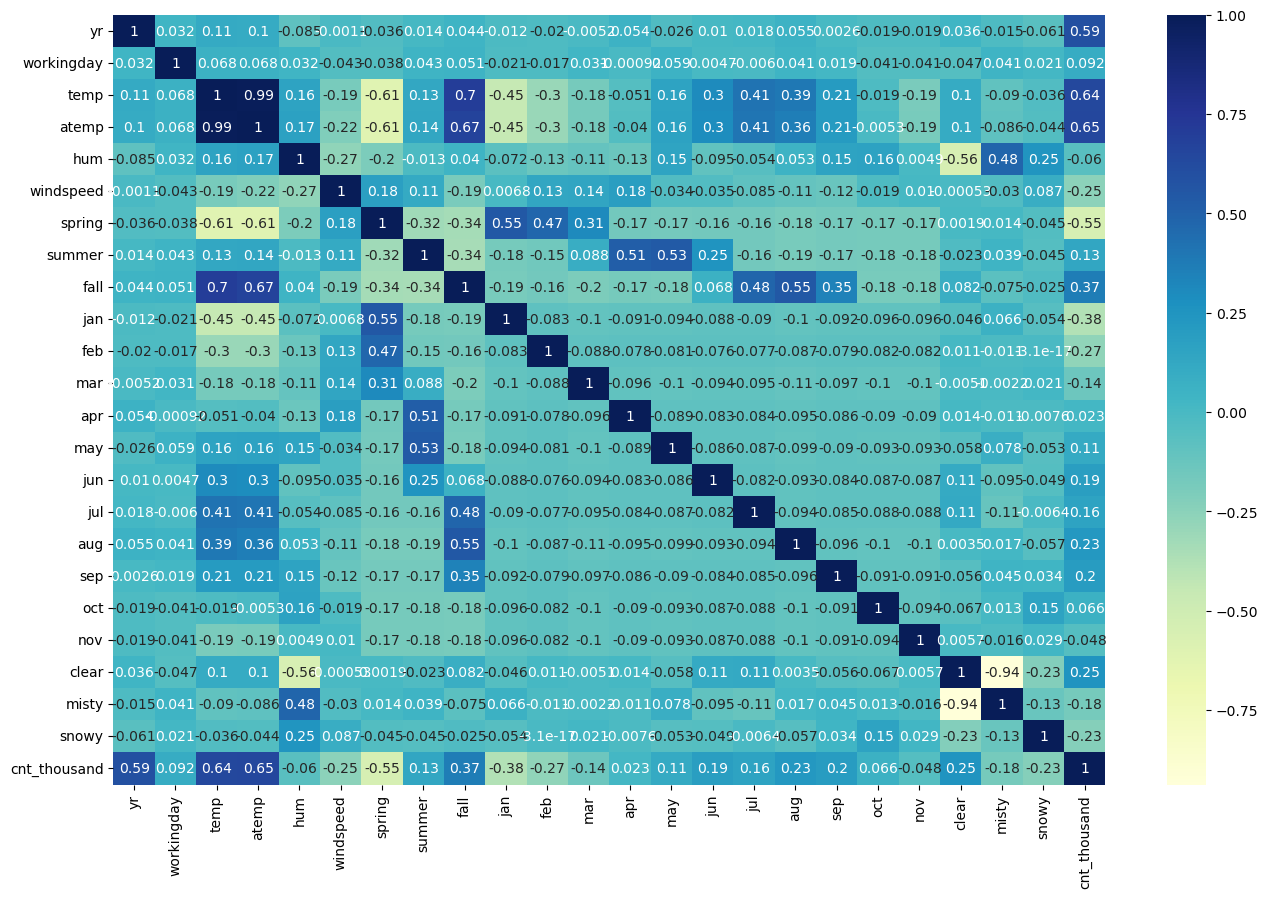

In [20]:
#Lets check how the correlation coefficients are spread for these regression columns using a box plot
plt.figure(figsize = (16, 10))
sns.heatmap(bike_train_reg.corr(), annot = True, cmap="YlGnBu")
plt.show()

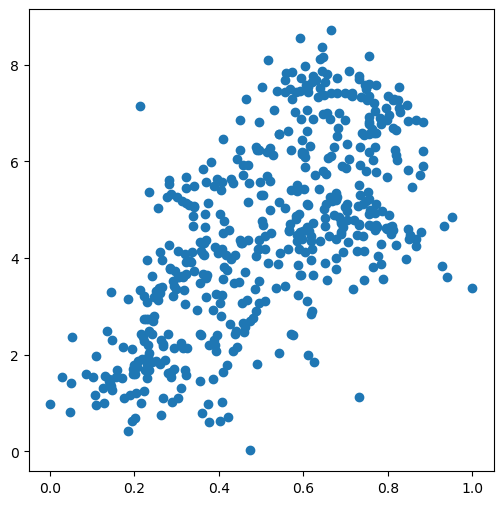

In [21]:
# we can see the feels like temperature (atemp) has the highest correlation to cnt among all other variables
# lets see this in a scatter plot i.e. atemp vs. cnt 

plt.figure(figsize=[6,6])
plt.scatter(bike_train_reg.atemp, bike_train_reg.cnt_thousand)
plt.show()

### Step 4.1: Building the linear model using forward pass
Our next step will be be to build a training model with these numeric and dummy variables (that we generated from 
various categories). At first we will do a `forward pass regression`, which means we will add one variable at a time 
and see the differences. 

In [22]:
# we will need the target variable for all of our regression models. Hence storing that before hand
y_train = bike_train_reg.pop('cnt_thousand')

# we will keep using columns from our X_train which contains our feature variables 
X_train = bike_train_reg

In [73]:
#defining a linear regression function using statsmodels.api that can be used to perform all the linear regressions
def linearRegressionStatsModelAPI(target_variable, feature_variables):
    #train on the feature variables
    X_train_lm = sm.add_constant(feature_variables)
    lr = sm.OLS(target_variable, X_train_lm).fit()
    
    #print the parameters
    print("The linear regressoin parameters are ::- ")
    print(lr.params)
    
    #print the summary 
    print("The linear regressoin summary is ::- ")
    print(lr.summary())
    
    #predit the count using the linear regression 
    y_train_count = lr.predict(X_train_lm)
    
    #perform residual analysis
    fig = plt.figure()
    sns.distplot((y_train - y_train_count), bins = 20)
    fig.suptitle('Error Terms', fontsize = 20)                  
    plt.xlabel('Errors', fontsize = 18)                         
    plt.show()
    
    #return the lr for further use
    return lr

#lets also define a function to visualize the data
def linearRegressionVisualizeData(target_variable, feature_data, constant, coefficient):
    plt.scatter(feature_data, target_variable)
    plt.plot(feature_data, constant + coefficient*feature_data, 'r')
    plt.show()
    
#when we add more feature variables we need to check the VIF too so we can 
#drop any multicolinear feature varibles. This function will help us with the VIF among the feature variables
def linearRegressionMeasureVIF(features):
    vif = pd.DataFrame()
    vif['Features'] = features.columns
    vif['VIF'] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    print(vif)

#### Model - 1 (feature - atemp, target - cnt)

The linear regressoin parameters are ::- 
const    1.438132
atemp    5.942135
dtype: float64
The linear regressoin summary is ::- 
                            OLS Regression Results                            
Dep. Variable:           cnt_thousand   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     364.7
Date:                Fri, 29 Mar 2024   Prob (F-statistic):           1.10e-61
Time:                        14:57:19   Log-Likelihood:                -926.32
No. Observations:                 510   AIC:                             1857.
Df Residuals:                     508   BIC:                             1865.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]


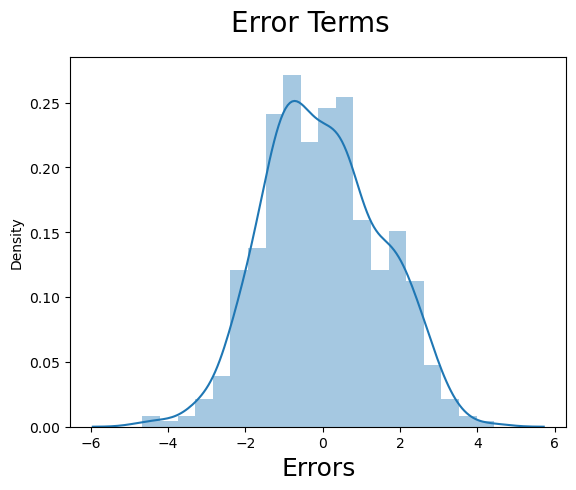

In [74]:
#call our linear regression function to perform the modeling
feature_cols_model1 = ['atemp']
lr1 = linearRegressionStatsModelAPI(y_train, X_train[feature_cols_model1])
# We got a very good model with:
# R-squared = 0.42
# Adjusted R-Squared = 0.42
# F-statistics = 364 which is pretty high
# p-value = 0 which is very good
# we can conclude by saying ~42% of biker's count can be explained by the "feels like" temperature. 

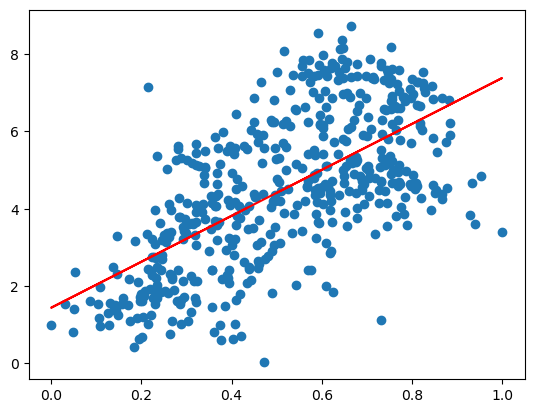

In [63]:
#next lets' visualize this data 
linearRegressionVisualizeData(y_train, X_train[feature_cols_model1], 1.4381, 5.9421)

#### Model - 2 (feature - atemp+yr, target - cnt)

The linear regressoin parameters are ::- 
const    0.648731
atemp    5.434592
yr       2.067106
dtype: float64
The linear regressoin summary is ::- 
                            OLS Regression Results                            
Dep. Variable:           cnt_thousand   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     579.5
Date:                Fri, 29 Mar 2024   Prob (F-statistic):          1.07e-131
Time:                        14:57:56   Log-Likelihood:                -760.96
No. Observations:                 510   AIC:                             1528.
Df Residuals:                     507   BIC:                             1541.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [

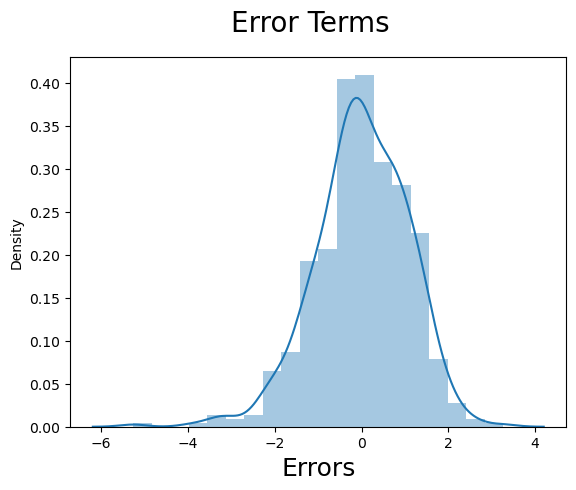

  Features   VIF
0    atemp  1.89
1       yr  1.89


In [75]:
#call our linear regression function to perform the modeling 
feature_cols_model2 = ['atemp','yr']
lr2 = linearRegressionStatsModelAPI(y_train, X_train[feature_cols_model2])
# We got a very good model with:
# R-squared = 0.69
# Adjusted R-Squared = 0.69 very close to r-squared
# F-statistics = 579 - increased which is pretty high
# p-value = 0 which is very good
# we can conclude by saying ~69% of biker's count can be explained by the "feels like" temperature and year. 

#check VIF for multicolinearity 
linearRegressionMeasureVIF(X_train[feature_cols_model2])
# The VIFs are very low (~2) for both the columns so we can safely say there is no multicolinieartiy among the features

#### Model - 3 (feature - atemp+yr+workingday, target - cnt)

The linear regressoin parameters are ::- 
const         0.561154
atemp         5.413282
yr            2.063636
workingday    0.148226
dtype: float64
The linear regressoin summary is ::- 
                            OLS Regression Results                            
Dep. Variable:           cnt_thousand   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     387.9
Date:                Fri, 29 Mar 2024   Prob (F-statistic):          1.02e-130
Time:                        14:59:36   Log-Likelihood:                -759.90
No. Observations:                 510   AIC:                             1528.
Df Residuals:                     506   BIC:                             1545.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef  

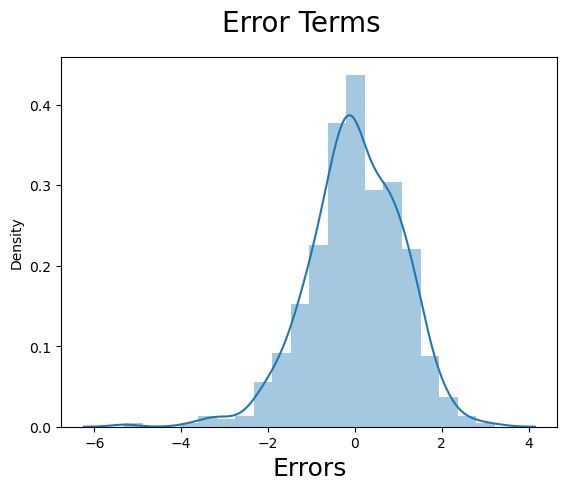

     Features   VIF
0       atemp  3.10
2  workingday  2.56
1          yr  1.93


In [76]:
#call our linear regression function to perform the modeling 
feature_cols_model3 = ['atemp','yr','workingday']
lr3 = linearRegressionStatsModelAPI(y_train, X_train[feature_cols_model3])

# We got a very good model with:
# R-squared = 0.69
# Adjusted R-Squared = 0.69 very close to r-squared
# F-statistics = dropped to 387 - indicating a potentially weaker overall fit of the model compared to a previous model.
# p-value for working day = 0.1 which is good but not as good as 0.0
# we can conclude by saying ~69% of biker's count can be explained by the "feels like" temperature, year, and 
# whether or not it is a working day. 

#check VIF for multicolinearity 
linearRegressionMeasureVIF(X_train[feature_cols_model3])
# The VIFs for atemp is increased to 3 which is still in the threashold of 5, 
# but other features VIFs remain ~2.0. 

#Action - At this time we are not taking any actions because all the values are within threashold and 
#         the R-squared is descent

#### Model - 4 (feature - atemp+yr+workingday+hum, target - cnt)

The linear regressoin parameters are ::- 
const         1.528483
atemp         5.611907
yr            2.014515
workingday    0.159910
hum          -1.617819
dtype: float64
The linear regressoin summary is ::- 
                            OLS Regression Results                            
Dep. Variable:           cnt_thousand   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     310.5
Date:                Fri, 29 Mar 2024   Prob (F-statistic):          1.41e-134
Time:                        14:59:46   Log-Likelihood:                -747.81
No. Observations:                 510   AIC:                             1506.
Df Residuals:                     505   BIC:                             1527.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         


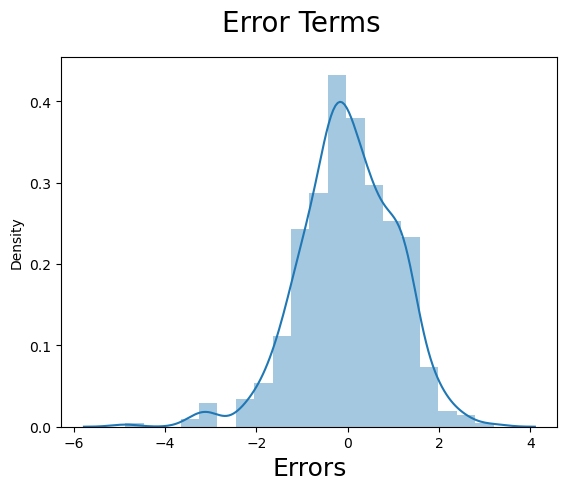

     Features   VIF
3         hum  7.41
0       atemp  6.61
2  workingday  2.95
1          yr  1.97


In [77]:
#call our linear regression function to perform the modeling 
feature_cols_model4 = ['atemp','yr','workingday','hum']
lr4 = linearRegressionStatsModelAPI(y_train, X_train[feature_cols_model4])

# We got a very good model with:
# R-squared = 0.71
# Adjusted R-Squared = 0.70 close to r-squared
# F-statistics = dropped to 310 - indicating a potentially weaker overall fit of the model compared to a previous model.
# p-value for humidity = 0.0, but working day increased to 0.111 which is good but not as good as 0.0
# we can conclude by saying ~70% of biker's count can be explained by the "feels like" temperature, year,  
# whether or not it is a working day, and the humidity. 

#check VIF for multicolinearity 
linearRegressionMeasureVIF(X_train[feature_cols_model4])
# The VIFs for atemp is increased to 6 and the VIF of humidity is 7, but other features VIFs remain ~2.0. 
# This strongly recommends atemp and humidity are multicoliniear

#Action - At this time it doesn't make sense to keep both humidity and atemp togather in this model. 
#         Considering the same we will drop the humidity in our next model, and thus we will become same as Model3. 

#### Model - 5 (feature - atemp+yr+workingday+windspeed, target - cnt)

The linear regressoin parameters are ::- 
const         1.183111
atemp         5.153388
yr            2.075039
workingday    0.132229
windspeed    -1.507643
dtype: float64
The linear regressoin summary is ::- 
                            OLS Regression Results                            
Dep. Variable:           cnt_thousand   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     314.1
Date:                Fri, 29 Mar 2024   Prob (F-statistic):          1.81e-135
Time:                        14:59:55   Log-Likelihood:                -745.73
No. Observations:                 510   AIC:                             1501.
Df Residuals:                     505   BIC:                             1523.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         


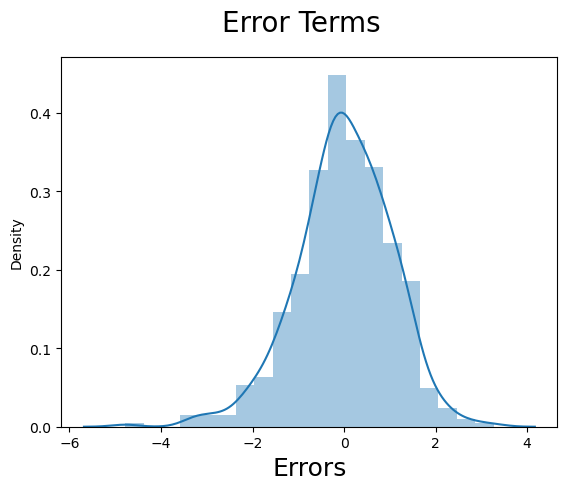

     Features   VIF
0       atemp  3.75
3   windspeed  2.85
2  workingday  2.74
1          yr  1.99


In [78]:
#call our linear regression function to perform the modeling 
feature_cols_model5 = ['atemp','yr','workingday','windspeed']
lr5 = linearRegressionStatsModelAPI(y_train, X_train[feature_cols_model5])

# We got a very good model with:
# R-squared = 0.71
# Adjusted R-Squared = 0.71 very close to r-squared
# F-statistics = increased a little bit to 314 
# p-value for windspeed = 0.0, but working day increased to 0.185 which is good but not as good as 0.0
# we can conclude by saying ~71% of biker's count can be explained by the "feels like" temperature, year,  
# whether or not it is a working day, and the windspeed. 

#check VIF for multicolinearity 
linearRegressionMeasureVIF(X_train[feature_cols_model5])
# The VIFs are within the threashold that is below 5. So we can ignore any concerns around multicoliniearity
# This strongly recommends atemp and humidity are multicoliniear

#Action - At this time we are not taking any actions because all the values are within threashold and 
#         the R-squared is descent

#### Model - 6 (feature - atemp+yr+workingday+windspeed+fall, target - cnt)
##### - Based on all the other seasons fall seems to have the highest correlation to count target variable. 

The linear regressoin parameters are ::- 
const         1.011201
atemp         5.759321
yr            2.065318
workingday    0.134180
windspeed    -1.567503
fall         -0.441905
dtype: float64
The linear regressoin summary is ::- 
                            OLS Regression Results                            
Dep. Variable:           cnt_thousand   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     257.6
Date:                Fri, 29 Mar 2024   Prob (F-statistic):          2.74e-136
Time:                        15:00:03   Log-Likelihood:                -740.84
No. Observations:                 510   AIC:                             1494.
Df Residuals:                     504   BIC:                             1519.
Df Model:                           5                                         
Covariance Type:            nonrobust                   

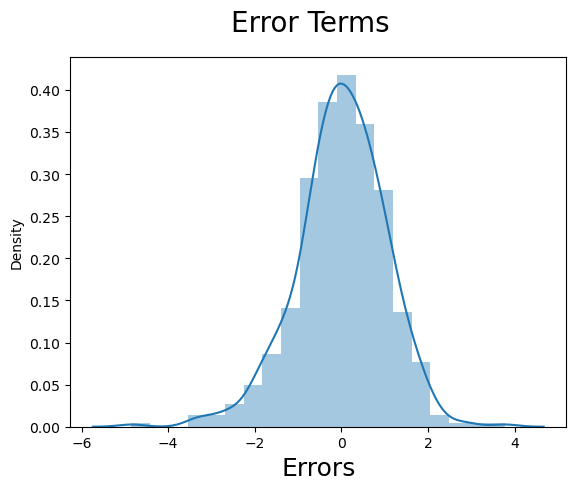

     Features   VIF
0       atemp  6.59
3   windspeed  3.15
2  workingday  2.77
4        fall  2.26
1          yr  2.01


In [79]:
#call our linear regression function to perform the modeling 
feature_cols_model6 = ['atemp','yr','workingday','windspeed','fall']
lr6 = linearRegressionStatsModelAPI(y_train, X_train[feature_cols_model6])

# We got a very good model with:
# R-squared = 0.71
# Adjusted R-Squared = 0.71 very close to r-squared
# F-statistics = dropped to 257
# p-value for fall = 0.002, but working day remains around 0.175 which is good but not as good as 0.0
# we can conclude by saying ~71% of biker's count can be explained by the "feels like" temperature, year,  
# whether or not it is a working day, the windspeed, and the season being fall. 

#check VIF for multicolinearity 
linearRegressionMeasureVIF(X_train[feature_cols_model6])
# The VIFs for atemp is increased to 6, but other features VIFs remain <= ~3.0. 
# This recommends atemp and fall weather may be multicoliniear

#Action - At this time it doesn't make sense to keep both faill and atemp togather in this model. 
#         Considering the same we will drop atemp in the next model and keep fall and see if there is any difference

#### Model - 7 (feature - yr+workingday+windspeed+fall, target - cnt)

The linear regressoin parameters are ::- 
const         3.552514
yr            2.247697
workingday    0.208906
windspeed    -2.199849
fall          1.357640
dtype: float64
The linear regressoin summary is ::- 
                            OLS Regression Results                            
Dep. Variable:           cnt_thousand   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     130.3
Date:                Fri, 29 Mar 2024   Prob (F-statistic):           2.31e-76
Time:                        15:00:12   Log-Likelihood:                -883.52
No. Observations:                 510   AIC:                             1777.
Df Residuals:                     505   BIC:                             1798.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         


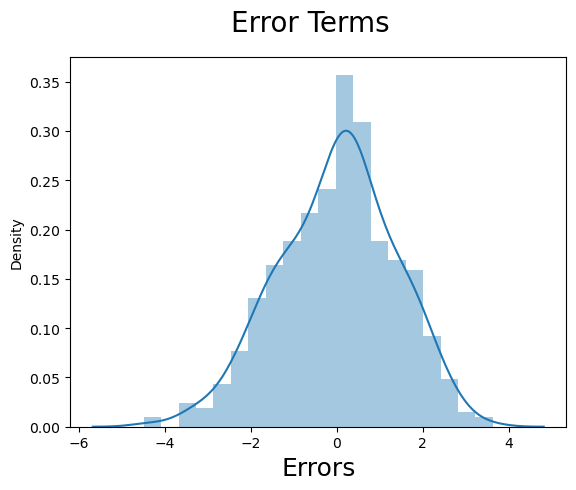

     Features   VIF
2   windspeed  2.36
1  workingday  2.34
0          yr  1.83
3        fall  1.29


In [80]:
#call our linear regression function to perform the modeling 
feature_cols_model7 = ['yr','workingday','windspeed','fall']
lr7 = linearRegressionStatsModelAPI(y_train, X_train[feature_cols_model7])

# We got a very good model with:
# R-squared = dropped to 0.508
# Adjusted R-Squared = 0.504 very close to r-squared
# F-statistics = dropped to 137
# p-value for fall = 0, but working day remains around 0.111 which is good but not as good as 0.0
# we can conclude by saying ~50% of biker's count can be explained by the year,  
# whether or not it is a working day, the windspeed, and the season being fall. 

#check VIF for multicolinearity 
linearRegressionMeasureVIF(X_train[feature_cols_model7])
# While the VIFs are within threashold, we dropped our Adjusted R-Squared signficantly

#Action - At this stage, we can say our Model #5 (atemp+yr+workingday+windspeed) was much stable and better.
#         Hence we will go back to that model and add the clear weather feature to see if it affects the model. 

#### Model - 8 (feature - atemp+yr+workingday+windspeed+clear, target - cnt)

The linear regressoin parameters are ::- 
const         0.178403
atemp         5.248747
yr            2.044475
workingday    0.189033
clear         0.716044
dtype: float64
The linear regressoin summary is ::- 
                            OLS Regression Results                            
Dep. Variable:           cnt_thousand   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     337.9
Date:                Fri, 29 Mar 2024   Prob (F-statistic):          3.11e-141
Time:                        15:00:41   Log-Likelihood:                -732.31
No. Observations:                 510   AIC:                             1475.
Df Residuals:                     505   BIC:                             1496.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         


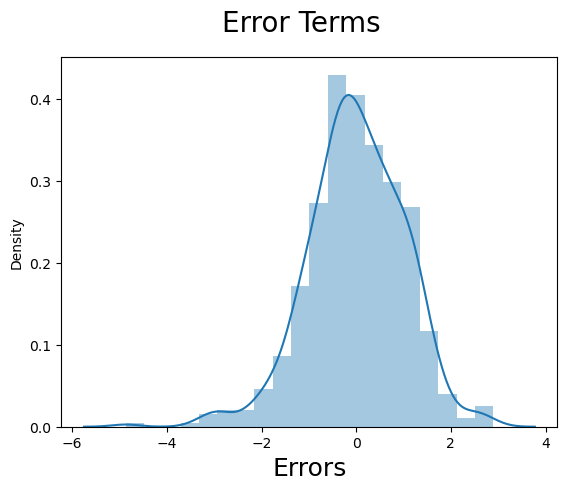

     Features   VIF
0       atemp  3.97
2  workingday  2.58
3       clear  2.39
1          yr  1.96


In [81]:
#call our linear regression function to perform the modeling 
feature_cols_model8 = ['atemp','yr','workingday','clear']
lr8 = linearRegressionStatsModelAPI(y_train, X_train[feature_cols_model8])

# We got a very good model with:
# R-squared = 0.728
# Adjusted R-Squared = 0.726 very close to r-squared
# F-statistics = increased to 337 
# p-value for clear = 0.0, also working day p-value dropped to 0.052 which is very good but not as good as 0.0
# we can conclude by saying ~72% of biker's count can be explained by the "feels like" temperature, year,  
# whether or not it is a working day, and a clear weather. 

#check VIF for multicolinearity 
linearRegressionMeasureVIF(X_train[feature_cols_model8])
# All the VIFs are within the threashold

#Action - At this time we are not taking any actions because all the values are within threashold and 
#         the R-squared is descent

#### Model - 9 (feature - atemp+yr+workingday+windspeed+clear+month(aug), target - cnt)
##### - From the heatmap, we can see the month August has the highest correlation to biker count among all other month. Hence will include it in the model and see if that makes any difference

The linear regressoin parameters are ::- 
const         0.166815
atemp         5.285083
yr            2.045243
workingday    0.189674
clear         0.714605
aug          -0.072578
dtype: float64
The linear regressoin summary is ::- 
                            OLS Regression Results                            
Dep. Variable:           cnt_thousand   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     269.9
Date:                Fri, 29 Mar 2024   Prob (F-statistic):          5.52e-140
Time:                        15:00:55   Log-Likelihood:                -732.21
No. Observations:                 510   AIC:                             1476.
Df Residuals:                     504   BIC:                             1502.
Df Model:                           5                                         
Covariance Type:            nonrobust                   

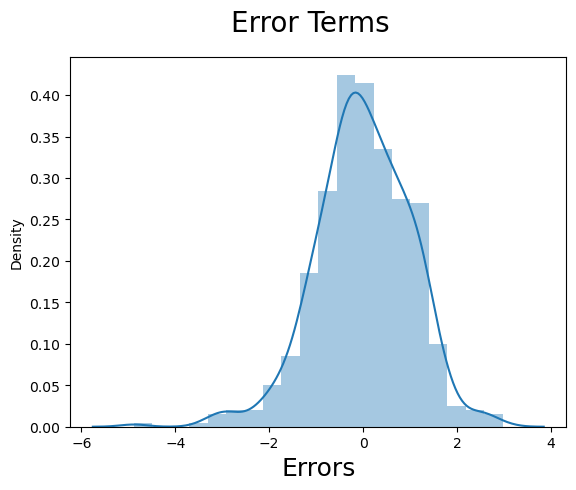

     Features   VIF
0       atemp  4.43
2  workingday  2.59
3       clear  2.42
1          yr  1.96
4         aug  1.23


In [82]:
#call our linear regression function to perform the modeling 
feature_cols_model9 = ['atemp','yr','workingday','clear','aug']
lr9 = linearRegressionStatsModelAPI(y_train, X_train[feature_cols_model9])

# We got a very good model with:
# R-squared = 0.728
# Adjusted R-Squared = 0.725 very close to r-squared
# F-statistics = dropped to 269  
# p-value for clear = 0.66, also working day p-value dropped to 0.052 which is very good but not as good as 0.0
# we can conclude by saying ~72% of biker's count can be explained by the "feels like" temperature, year,  
# whether or not it is a working day, a clear weather, and the month of august. 

#check VIF for multicolinearity 
linearRegressionMeasureVIF(X_train[feature_cols_model9])
# All the VIFs are within the threashold, but 

#Action - Although all VIFs are within threashold, p-values are close to 0, the F-statistics however have 
#         dropped indicating a potentially weaker overall fit of the model compared to a previous model.
#         Hence we consider the Model #8 as our final model and proceed further. 

### Step 4.2: Building the linear model using backward pass
Our next step will be be to build a training model with the numeric and dummy variables (that we generated from 
various categories). We will now do a `backward pass regression`, which means we will add all the variables and then 
drop them one by one based on VIFs. 

#### Model - 10 (feature - all features sets, target - cnt)

The linear regressoin parameters are ::- 
const         1.850628
yr            2.008716
workingday    0.187976
temp          3.432555
atemp         0.448272
hum          -1.441986
windspeed    -1.597178
spring       -1.364902
summer       -0.613304
fall         -0.971611
jan          -0.164213
feb           0.064351
mar           0.432716
apr           0.389584
may           0.631620
jun           0.431088
jul           0.116202
aug           0.620139
sep           1.138696
oct           0.426336
nov          -0.046187
clear         1.491193
misty         1.003319
snowy        -0.643884
dtype: float64
The linear regressoin summary is ::- 
                            OLS Regression Results                            
Dep. Variable:           cnt_thousand   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     121.2
Date:                Fri, 29 Mar 2024

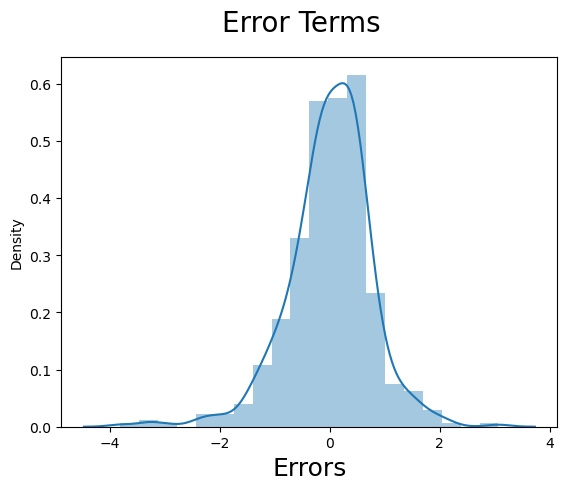

      Features    VIF
2         temp  65.86
3        atemp  55.20
20       clear  42.53
21       misty  29.85
7       summer  10.62
8         fall   9.80
6       spring   8.01
16         aug   7.74
15         jul   6.96
13         may   6.25
14         jun   5.89
12         apr   5.28
17         sep   4.67
22       snowy   4.07
11         mar   3.92
9          jan   3.67
10         feb   2.99
18         oct   2.53
19         nov   2.21
4          hum   2.03
5    windspeed   1.30
0           yr   1.05
1   workingday   1.02


In [83]:
#call our linear regression function to perform the modeling 
feature_cols_model10 = ['yr', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 
                        'spring', 'summer', 'fall', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 
                        'jul', 'aug', 'sep', 'oct', 'nov', 'clear', 'misty', 'snowy']
lr10 = linearRegressionStatsModelAPI(y_train, X_train[feature_cols_model10])

# We got a very good model with:
# R-squared = 0.84
# Adjusted R-Squared = 0.83 very close to r-squared
# F-statistics = 121  
# p-value for clear = Mostly 0.00s, except atemp, feb, jul which are close to 1
# we can conclude by saying ~82% of biker's count can be explained by all the feature variables present in the dataset
# We can also see the following featres has a negative coefficient which means they are tending to drop 
# the bikers count - hum, windspeed, spring, summer, fall, jan

#check VIF for multicolinearity 
linearRegressionMeasureVIF(X_train[feature_cols_model10])
# The temp, atemp, clear, misty, summer etc. VIFs are very high

#Action - We will drop the temp feature variable in the next model and see if it changes anything
#         Along side we will also drop the variables which has the negative coefficients

#### Model - 11 (feature - all features minus temp, target - cnt)

The linear regressoin parameters are ::- 
const        -0.090399
yr            2.041705
workingday    0.216259
atemp         4.118513
feb          -0.370721
mar           0.243795
apr           0.616226
may           0.890340
jun           0.713219
jul           0.187332
aug           0.706045
sep           1.353955
oct           1.287036
nov           0.875204
clear         1.036025
misty         0.352740
snowy        -1.479164
dtype: float64
The linear regressoin summary is ::- 
                            OLS Regression Results                            
Dep. Variable:           cnt_thousand   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     129.3
Date:                Fri, 29 Mar 2024   Prob (F-statistic):          4.17e-160
Time:                        15:01:09   Log-Likelihood:                -657.67
No. Observations:                 510   

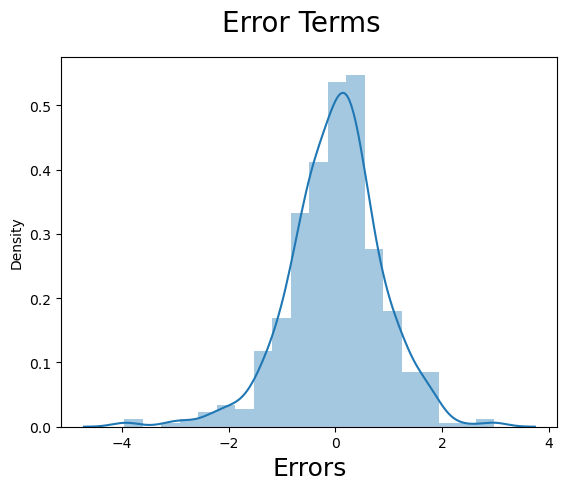

      Features    VIF
13       clear  10.24
14       misty   5.73
2        atemp   4.93
8          jul   3.63
9          aug   3.58
7          jun   2.96
10         sep   2.61
6          may   2.46
11         oct   1.92
5          apr   1.71
4          mar   1.59
12         nov   1.50
15       snowy   1.46
3          feb   1.30
0           yr   1.03
1   workingday   1.02


In [84]:
#call our linear regression function to perform the modeling 
feature_cols_model11 = ['yr', 'workingday', 'atemp', 
                        'feb', 'mar', 'apr', 'may', 'jun', 
                        'jul', 'aug', 'sep', 'oct', 'nov', 'clear', 'misty', 'snowy']
lr11 = linearRegressionStatsModelAPI(y_train, X_train[feature_cols_model11])

# We got a very good model with:
# R-squared = 0.79
# Adjusted R-Squared = 0.79 very close to r-squared
# F-statistics = 129 (increased)  
# p-value for clear = Mostly 0.00s, except jul

#check VIF for multicolinearity 
linearRegressionMeasureVIF(X_train[feature_cols_model11])
# Mostly within threashold except clear wether

#Action - We will drop the clear weather feature variable and see if it changes anything

#### Model - 12 (feature - all features minus temp+clear weather+-ve coeffs, target - cnt)

The linear regressoin parameters are ::- 
const         0.945626
yr            2.041705
workingday    0.216259
atemp         4.118513
feb          -0.370721
mar           0.243795
apr           0.616226
may           0.890340
jun           0.713219
jul           0.187332
aug           0.706045
sep           1.353955
oct           1.287036
nov           0.875204
misty        -0.683286
snowy        -2.515189
dtype: float64
The linear regressoin summary is ::- 
                            OLS Regression Results                            
Dep. Variable:           cnt_thousand   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     129.3
Date:                Fri, 29 Mar 2024   Prob (F-statistic):          4.17e-160
Time:                        15:01:18   Log-Likelihood:                -657.67
No. Observations:                 510   AIC:                   

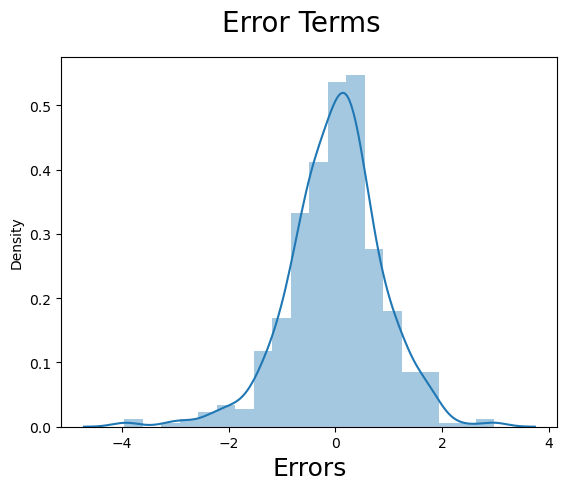

      Features    VIF
2        atemp  19.03
9          aug   3.59
8          jul   3.54
7          jun   2.98
1   workingday   2.87
10         sep   2.69
6          may   2.57
11         oct   2.10
0           yr   2.04
5          apr   1.85
4          mar   1.74
12         nov   1.60
13       misty   1.51
3          feb   1.26
14       snowy   1.09


In [85]:
#call our linear regression function to perform the modeling 
feature_cols_model12 = ['yr', 'workingday', 'atemp', 
                        'feb', 'mar', 'apr', 'may', 'jun', 
                        'jul', 'aug', 'sep', 'oct', 'nov', 'misty', 'snowy']
lr12 = linearRegressionStatsModelAPI(y_train, X_train[feature_cols_model12])

# We got a very good model with:
# R-squared = 0.79
# Adjusted R-Squared = 0.79 very close to r-squared
# F-statistics = 129 (remained same)  
# p-value for clear = Mostly 0.00s, except jul

#check VIF for multicolinearity 
linearRegressionMeasureVIF(X_train[feature_cols_model12])
# Mostly within threashold except clear wether, except atemp which bumped up to 19

#Action - We will drop the atemp feature variable and see if it changes anything

#### Model - 13 (feature - all features minus temp+clear weather+atemp+-ve coeffs, target - cnt)

The linear regressoin parameters are ::- 
const         1.995445
yr            2.136337
workingday    0.252156
feb          -0.336571
mar           0.780822
apr           1.495442
may           2.369338
jun           2.619295
jul           2.421728
aug           2.668431
sep           2.977038
oct           2.297767
nov           1.362753
misty        -0.729127
snowy        -2.632115
dtype: float64
The linear regressoin summary is ::- 
                            OLS Regression Results                            
Dep. Variable:           cnt_thousand   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     109.7
Date:                Fri, 29 Mar 2024   Prob (F-statistic):          1.16e-141
Time:                        15:01:23   Log-Likelihood:                -704.31
No. Observations:                 510   AIC:                             1439.
Df Resi

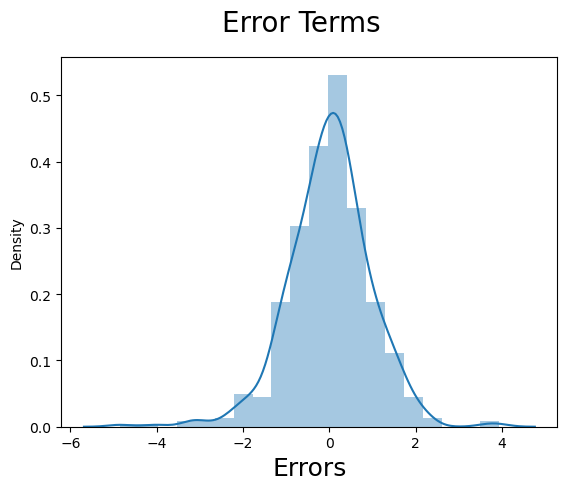

      Features   VIF
1   workingday  2.56
0           yr  1.87
12       misty  1.48
8          aug  1.27
3          mar  1.24
5          may  1.24
10         oct  1.22
9          sep  1.21
4          apr  1.20
7          jul  1.17
11         nov  1.17
6          jun  1.16
2          feb  1.14
13       snowy  1.09


In [86]:
#call our linear regression function to perform the modeling 
feature_cols_model13 = ['yr', 'workingday', 
                        'feb', 'mar', 'apr', 'may', 'jun', 
                        'jul', 'aug', 'sep', 'oct', 'nov', 'misty', 'snowy']

lr13 = linearRegressionStatsModelAPI(y_train, X_train[feature_cols_model13])

# We got a very good model with:
# R-squared = 0.75
# Adjusted R-Squared = 0.74 very close to r-squared
# F-statistics = 109 (decreased)  
# p-value for clear = Mostly 0.00s, except jul

#check VIF for multicolinearity 
linearRegressionMeasureVIF(X_train[feature_cols_model13])
# All the VIFs are within threashold

#Action - Althought F-Statistics is dropped, since the p-values are mostly 0 and the adjusted r-squared 
#         is close to r-squared we can consider this as an apt model as well. 

### Step 4.3: Building the linear model using RFE
Our next step will be be to build a training model with the numeric and dummy variables (that we generated from 
various categories). We will now do a `RFE` package from `sklearn.feature_selection`, to identify the feature
variables for the regression model

#### Model - 14 (feature - all features with ref support = true, and cnt)

In [38]:
#create a new object of the LinearRegression from sklearn.linear_model
linReg = LinearRegression()

#run the fitting process
linReg.fit(X_train, y_train)

#create an RFE object with 23 steps considering we have 23 feature variables
rfe = RFE(linReg, step=23)             

#run the fit process on the rfe instance
rfe = rfe.fit(X_train, y_train)

#show the list of columns with the support field
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

#we can see there are at least 10 columns where support is True

[('yr', True, 1),
 ('workingday', False, 2),
 ('temp', True, 1),
 ('atemp', False, 2),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('spring', True, 1),
 ('summer', False, 2),
 ('fall', True, 1),
 ('jan', False, 2),
 ('feb', False, 2),
 ('mar', False, 2),
 ('apr', False, 2),
 ('may', True, 1),
 ('jun', False, 2),
 ('jul', False, 2),
 ('aug', True, 1),
 ('sep', True, 1),
 ('oct', False, 2),
 ('nov', False, 2),
 ('clear', True, 1),
 ('misty', False, 2),
 ('snowy', True, 1)]

The linear regressoin parameters are ::- 
const        2.778176
yr           2.003901
temp         4.161516
hum         -1.334994
windspeed   -1.655128
spring      -1.234427
fall        -0.896229
may         -0.019114
aug          0.446622
sep          1.005864
clear        0.497128
snowy       -1.516663
dtype: float64
The linear regressoin summary is ::- 
                            OLS Regression Results                            
Dep. Variable:           cnt_thousand   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     227.6
Date:                Fri, 29 Mar 2024   Prob (F-statistic):          2.98e-186
Time:                        15:01:43   Log-Likelihood:                -606.24
No. Observations:                 510   AIC:                             1236.
Df Residuals:                     498   BIC:                             1287.
Df Model:

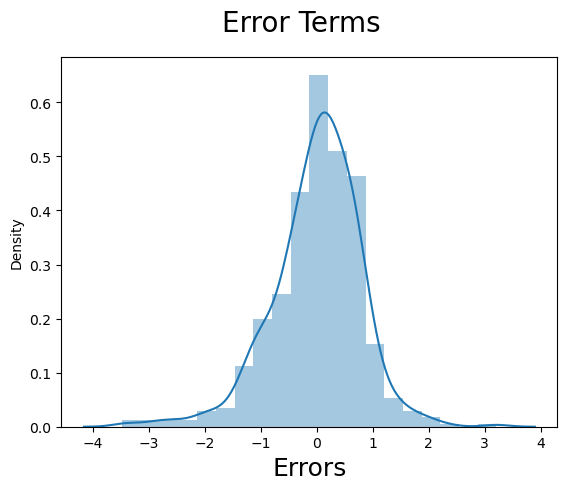

     Features    VIF
1        temp  20.53
2         hum  12.18
5        fall   4.61
3   windspeed   4.21
9       clear   2.94
0          yr   2.06
4      spring   1.97
7         aug   1.85
8         sep   1.50
6         may   1.36
10      snowy   1.15


In [87]:
#Lets grab those support column in a feature list 
feature_cols_model14 = X_train.columns[rfe.support_]

lr14 = linearRegressionStatsModelAPI(y_train, X_train[feature_cols_model14])

# We got a very good model with:
# R-squared = 0.830
# Adjusted R-Squared = 0.834 very close to r-squared
# F-statistics = 227 (increased)  
# p-value for most of the variable is 0, except may which is at 0.894

#check VIF for multicolinearity 
linearRegressionMeasureVIF(X_train[feature_cols_model14])
# VIFs for temp and hum is very high and beyond threashold. 

#Action - We will drop the may feature field as it seems to have high VIF indicating multicoliearity
#         and see if this affects the model in any way

#### Model - 15 (feature - all features with ref support - may feature = true, and cnt)

The linear regressoin parameters are ::- 
const        2.782020
yr           2.004476
temp         4.149599
hum         -1.337676
windspeed   -1.654674
spring      -1.233919
fall        -0.889919
aug          0.447115
sep          1.006547
clear        0.497601
snowy       -1.514164
dtype: float64
The linear regressoin summary is ::- 
                            OLS Regression Results                            
Dep. Variable:           cnt_thousand   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     250.9
Date:                Fri, 29 Mar 2024   Prob (F-statistic):          1.85e-187
Time:                        15:01:48   Log-Likelihood:                -606.25
No. Observations:                 510   AIC:                             1234.
Df Residuals:                     499   BIC:                             1281.
Df Model:                      

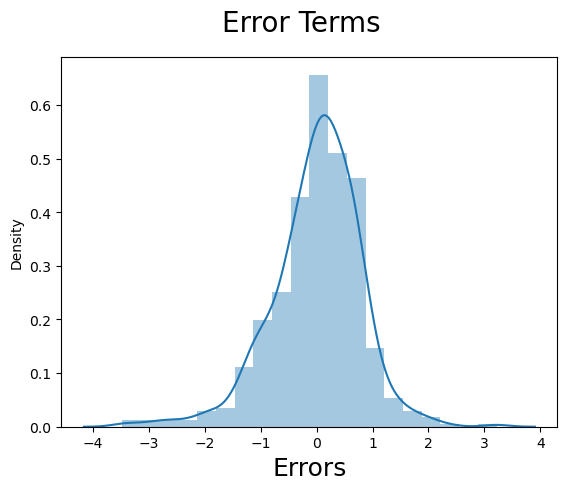

    Features    VIF
1       temp  18.71
2        hum  12.16
3  windspeed   4.19
5       fall   4.16
8      clear   2.91
0         yr   2.05
4     spring   1.96
6        aug   1.85
7        sep   1.49
9      snowy   1.14


In [88]:
#Lets grab those support column in a feature list 
feature_cols_model15 = X_train.columns[rfe.support_]
columns_to_drop = ['may']
feature_cols_model15 = feature_cols_model15.drop(columns_to_drop)

lr15 = linearRegressionStatsModelAPI(y_train, X_train[feature_cols_model15])

# We got a very good model with:
# R-squared = 0.830
# Adjusted R-Squared = 0.831 very close to r-squared
# F-statistics = 250 (increased)  
# p-value for most of the variable is 0, except aug which is at 0.001 which very cloes to 0.00

#check VIF for multicolinearity 
linearRegressionMeasureVIF(X_train[feature_cols_model15])
# VIFs for temp and hum are still very high and beyond threashold. 

#Action - We will drop the temp feature field as it seems to have high VIF indicating multicoliearity
#         and see if this affects the model in any way

#### Model - 16 (feature - all features with ref support - may - temp feature = true, and cnt)

The linear regressoin parameters are ::- 
const        3.962577
yr           2.144741
hum         -0.289377
windspeed   -1.463715
spring      -2.101588
fall         0.369584
aug          0.354406
sep          0.730550
clear        0.742310
snowy       -1.779842
dtype: float64
The linear regressoin summary is ::- 
                            OLS Regression Results                            
Dep. Variable:           cnt_thousand   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     173.5
Date:                Fri, 29 Mar 2024   Prob (F-statistic):          1.33e-147
Time:                        15:01:53   Log-Likelihood:                -703.10
No. Observations:                 510   AIC:                             1426.
Df Residuals:                     500   BIC:                             1469.
Df Model:                           9                

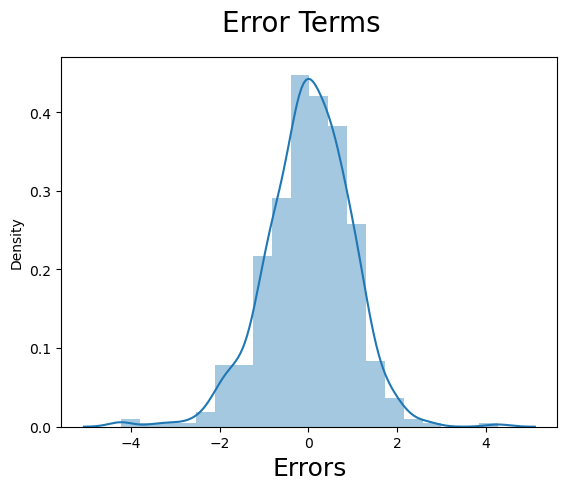

    Features   VIF
1        hum  4.75
2  windspeed  4.01
4       fall  2.69
7      clear  2.44
0         yr  1.98
5        aug  1.85
3     spring  1.49
6        sep  1.47
8      snowy  1.13


In [89]:
#Lets grab those support column in a feature list 
feature_cols_model16 = X_train.columns[rfe.support_]
columns_to_drop = ['may','temp']
feature_cols_model16 = feature_cols_model16.drop(columns_to_drop)

lr16 = linearRegressionStatsModelAPI(y_train, X_train[feature_cols_model16])

# We got a very good model with:
# R-squared = 0.757
# Adjusted R-Squared dropped = 0.753 very close to r-squared
# F-statistics = 173 (dropped)  
# p-value for most of the variable is 0, except aug which is at 0.061 which very cloes to 0.00

#check VIF for multicolinearity 
linearRegressionMeasureVIF(X_train[feature_cols_model16])
# VIFs for all fields are within threashold

#Action - While this can be an acceptable model, we want to see what happens if we drop hum feature 
#         instead of temp. Does it changes the model in any way

#### Model - 17 (feature - all features with ref support - may - hum feature = true, and cnt)

The linear regressoin parameters are ::- 
const        1.779805
yr           2.035953
temp         3.921212
windspeed   -1.370785
spring      -1.216435
fall        -0.787013
aug          0.401707
sep          0.924183
clear        0.708797
snowy       -1.681858
dtype: float64
The linear regressoin summary is ::- 
                            OLS Regression Results                            
Dep. Variable:           cnt_thousand   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     268.8
Date:                Fri, 29 Mar 2024   Prob (F-statistic):          3.08e-185
Time:                        15:01:57   Log-Likelihood:                -614.39
No. Observations:                 510   AIC:                             1249.
Df Residuals:                     500   BIC:                             1291.
Df Model:                           9                

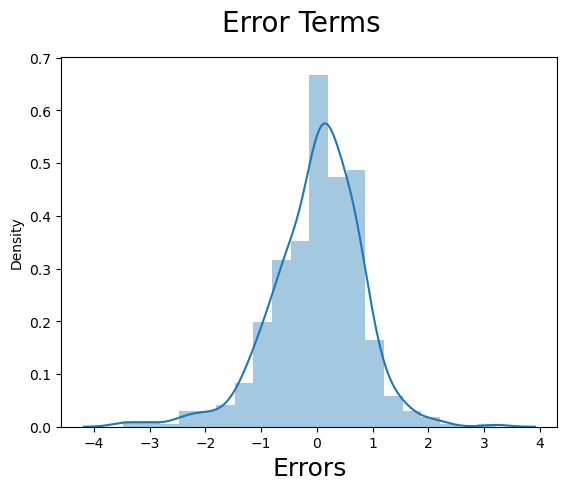

    Features   VIF
1       temp  7.31
2  windspeed  4.07
4       fall  3.52
7      clear  2.78
0         yr  2.04
5        aug  1.84
3     spring  1.56
6        sep  1.43
8      snowy  1.09


In [90]:
#Lets grab those support column in a feature list 
feature_cols_model17 = X_train.columns[rfe.support_]
columns_to_drop = ['may','hum']
feature_cols_model17 = feature_cols_model17.drop(columns_to_drop)

lr17 = linearRegressionStatsModelAPI(y_train, X_train[feature_cols_model17])

# We got a very good model with:
# R-squared = 0.829
# Adjusted R-Squared dropped = 0.826 very close to r-squared
# F-statistics = 268 (increased)  
# p-value for most of the variable is 0, except aug which is at 0.011 which very cloes to 0.00

#check VIF for multicolinearity 
linearRegressionMeasureVIF(X_train[feature_cols_model17])
# VIF for temp is beyond acceptable limit

#Action - This is not an acceptable model considering temp showing high multicoliniearity. At this stage we
#         can either stop at the model #16 or extend further by dropping both hum and temp. Lets do that

#### Model - 18 (feature - all features with ref support - may - hum - temp feature = true, and cnt)

The linear regressoin parameters are ::- 
const        3.721307
yr           2.150112
windspeed   -1.401910
spring      -2.086838
fall         0.377177
aug          0.345294
sep          0.715363
clear        0.787012
snowy       -1.814449
dtype: float64
The linear regressoin summary is ::- 
                            OLS Regression Results                            
Dep. Variable:           cnt_thousand   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     195.3
Date:                Fri, 29 Mar 2024   Prob (F-statistic):          1.21e-148
Time:                        15:02:03   Log-Likelihood:                -703.38
No. Observations:                 510   AIC:                             1425.
Df Residuals:                     501   BIC:                             1463.
Df Model:                           8                                      

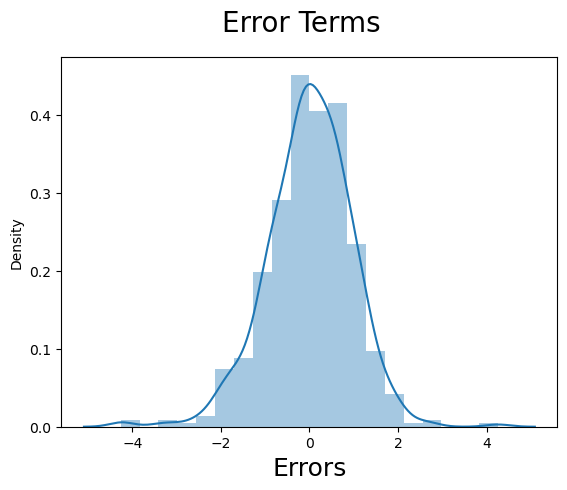

    Features   VIF
1  windspeed  2.81
3       fall  2.64
6      clear  2.35
4        aug  1.83
0         yr  1.82
2     spring  1.46
5        sep  1.43
7      snowy  1.09


In [91]:
#Lets grab those support column in a feature list 
feature_cols_model18 = X_train.columns[rfe.support_]
columns_to_drop = ['may','hum','temp']
feature_cols_model18 = feature_cols_model18.drop(columns_to_drop)

lr18 = linearRegressionStatsModelAPI(y_train, X_train[feature_cols_model18])

# We got a very good model with:
# R-squared = 0.757
# Adjusted R-Squared dropped = 0.753 very close to r-squared
# F-statistics = 195 (decreased)  
# p-value for most of the variable is 0, except aug which is at 0.067 which very cloes to 0.00

#check VIF for multicolinearity 
linearRegressionMeasureVIF(X_train[feature_cols_model18])
# All VIFs are within the acceptable threshold 

#Action - Although the Adjusted R-Squared dropped we don't have any multicoliniearit. Hence we can consider 
#         the model 18 as the final model 

### Step 5: Making Predictions Using the Final Model
Our next step is to make prediction using the models which we found apt. For this we will use:
- Model 8 from forward pass ['atemp','yr','workingday','clear']
- Model 13 from backward pass ['yr','workingday','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','misty','snowy']

In [44]:
bike_test.head()

instant      dteday  yr  holiday  weekday  workingday       temp  \
184      185    4/7/2018   0        1        1           0  29.793347   
535      536  20-06-2019   1        0        3           1  32.082500   
299      300  27-10-2018   0        0        4           1  19.270000   
221      222   10/8/2018   0        0        3           1  31.433347   
152      153    2/6/2018   0        0        4           1  29.315000   

        atemp      hum  windspeed  ...  jul  jun  mar  may  nov  oct  sep  \
184  33.27085  63.7917   5.459106  ...    1    0    0    0    0    0    0   
535  36.04875  59.2083   7.625404  ...    0    1    0    0    0    0    0   
299  22.85230  81.2917  13.250121  ...    0    0    0    0    0    1    0   
221  34.24915  42.4167  13.417286  ...    0    0    0    0    0    0    0   
152  32.19710  30.5000  19.583229  ...    0    1    0    0    0    0    0   

     clear  misty  snowy  
184      0      1      0  
535      1      0      0  
299      0      1      0  
221      1      0      0  
152      1      0      0  

[5 rows x 30 columns]

In [45]:
#before we move on we need to scale the data same as what we did for the training set
features_to_scale = ['yr', 'workingday', 'temp', 'atemp', 'hum', 'windspeed']
scaleMinMax(features_to_scale, bike_test)

#our target variable i.e. the cnt column is in 1000s which will skew the cofficients of the numeric
#variables because they are scaled now. We can add a new column called cnt_thousand that will represent the 
#count in thousands and thus can be used as the target variable
bike_test['cnt_thousand'] = bike_test['cnt'] / 1000

bike_test.head()

instant      dteday   yr  holiday  weekday  workingday      temp  \
184      185    4/7/2018  0.0        1        1         0.0  0.837241   
535      536  20-06-2019  1.0        0        3         1.0  0.911423   
299      300  27-10-2018  0.0        0        4         1.0  0.496221   
221      222   10/8/2018  0.0        0        3         1.0  0.890387   
152      153    2/6/2018  0.0        0        4         1.0  0.821739   

        atemp       hum  windspeed  ...  jun  mar  may  nov  oct  sep  clear  \
184  0.778767  0.534223   0.149393  ...    0    0    0    0    0    0      0   
535  0.855132  0.470417   0.231142  ...    1    0    0    0    0    0      1   
299  0.492359  0.777843   0.443398  ...    0    0    0    0    1    0      0   
221  0.805661  0.236659   0.449707  ...    0    0    0    0    0    0      1   
152  0.749249  0.070765   0.682387  ...    1    0    0    0    0    0      1   

     misty  snowy  cnt_thousand  
184      1      0         6.043  
535      0      0         6.211  
299      1      0         2.659  
221      0      0         4.780  
152      0      0         4.968  

[5 rows x 31 columns]

In [46]:
#isolate the columns from the training set that will be required for regression
reg_cols = ['yr', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 
            'spring', 'summer', 'fall', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 
            'jul', 'aug', 'sep', 'oct', 'nov', 'clear', 'misty', 'snowy', 'cnt_thousand']

bike_test_reg = bike_test [reg_cols]
bike_test_reg.head()

yr  workingday      temp     atemp       hum  windspeed  spring  summer  \
184  0.0         0.0  0.837241  0.778767  0.534223   0.149393       0       0   
535  1.0         1.0  0.911423  0.855132  0.470417   0.231142       0       1   
299  0.0         1.0  0.496221  0.492359  0.777843   0.443398       0       0   
221  0.0         1.0  0.890387  0.805661  0.236659   0.449707       0       0   
152  0.0         1.0  0.821739  0.749249  0.070765   0.682387       0       1   

     fall  jan  ...  jun  jul  aug  sep  oct  nov  clear  misty  snowy  \
184     1    0  ...    0    1    0    0    0    0      0      1      0   
535     0    0  ...    1    0    0    0    0    0      1      0      0   
299     0    0  ...    0    0    0    0    1    0      0      1      0   
221     1    0  ...    0    0    1    0    0    0      1      0      0   
152     0    0  ...    1    0    0    0    0    0      1      0      0   

     cnt_thousand  
184         6.043  
535         6.211  
299         2.659  
221         4.780  
152         4.968  

[5 rows x 24 columns]

In [47]:
# we will need the target variable for all of our regression models. Hence storing that before hand
y_test = bike_test_reg.pop('cnt_thousand')

# we will keep using columns from our X_train which contains our feature variables 
X_test = bike_test_reg

In [48]:
y_test.head()

184    6.043
535    6.211
299    2.659
221    4.780
152    4.968
Name: cnt_thousand, dtype: float64

In [49]:
X_test.head()

yr  workingday      temp     atemp       hum  windspeed  spring  summer  \
184  0.0         0.0  0.837241  0.778767  0.534223   0.149393       0       0   
535  1.0         1.0  0.911423  0.855132  0.470417   0.231142       0       1   
299  0.0         1.0  0.496221  0.492359  0.777843   0.443398       0       0   
221  0.0         1.0  0.890387  0.805661  0.236659   0.449707       0       0   
152  0.0         1.0  0.821739  0.749249  0.070765   0.682387       0       1   

     fall  jan  ...  may  jun  jul  aug  sep  oct  nov  clear  misty  snowy  
184     1    0  ...    0    0    1    0    0    0    0      0      1      0  
535     0    0  ...    0    1    0    0    0    0    0      1      0      0  
299     0    0  ...    0    0    0    0    0    1    0      0      1      0  
221     1    0  ...    0    0    0    1    0    0    0      1      0      0  
152     0    0  ...    0    1    0    0    0    0    0      1      0      0  

[5 rows x 23 columns]

#### Step 5.1 - Use Model - 8 (feature - atemp+yr+workingday+windspeed+clear, target - cnt) to assess the test data

In [50]:
#get the columns used in model 8 
feature_cols_model8 = ['atemp','yr','workingday','clear']

#take the same columns that we used in model 8 
X_test_m8 = X_test[feature_cols_model8]

# Adding a constant variable 
X_test_m8 = sm.add_constant(X_test_m8)

#make prediction with the lr8 model
y_pred_m8 = lr8.predict(X_test_m8)

##### Step 5.1.1 - Evaluate the model

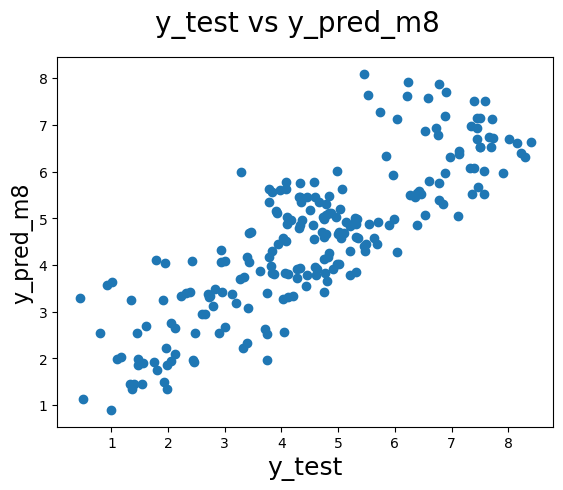

In [51]:
# Plotting y_test and y_pred_m8 to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred_m8)
fig.suptitle('y_test vs y_pred_m8', fontsize=20)              
plt.xlabel('y_test', fontsize=18)                          
plt.ylabel('y_pred_m8', fontsize=16)   
plt.show()

In [52]:
#Check the MSE and r-square scores
mse = mean_squared_error(bike_test['cnt_thousand'], y_pred_m8)
r_squared = r2_score(bike_test['cnt_thousand'], y_pred_m8)

print('Mean_Squared_Error Model 8:', mse)
print('r_square_value Model 8:', r_squared)

#We can see the r-squared is very close to what is determined for model 8

Mean_Squared_Error Model 8: 1.0830242927217897
r_square_value Model 8: 0.6981831506744348


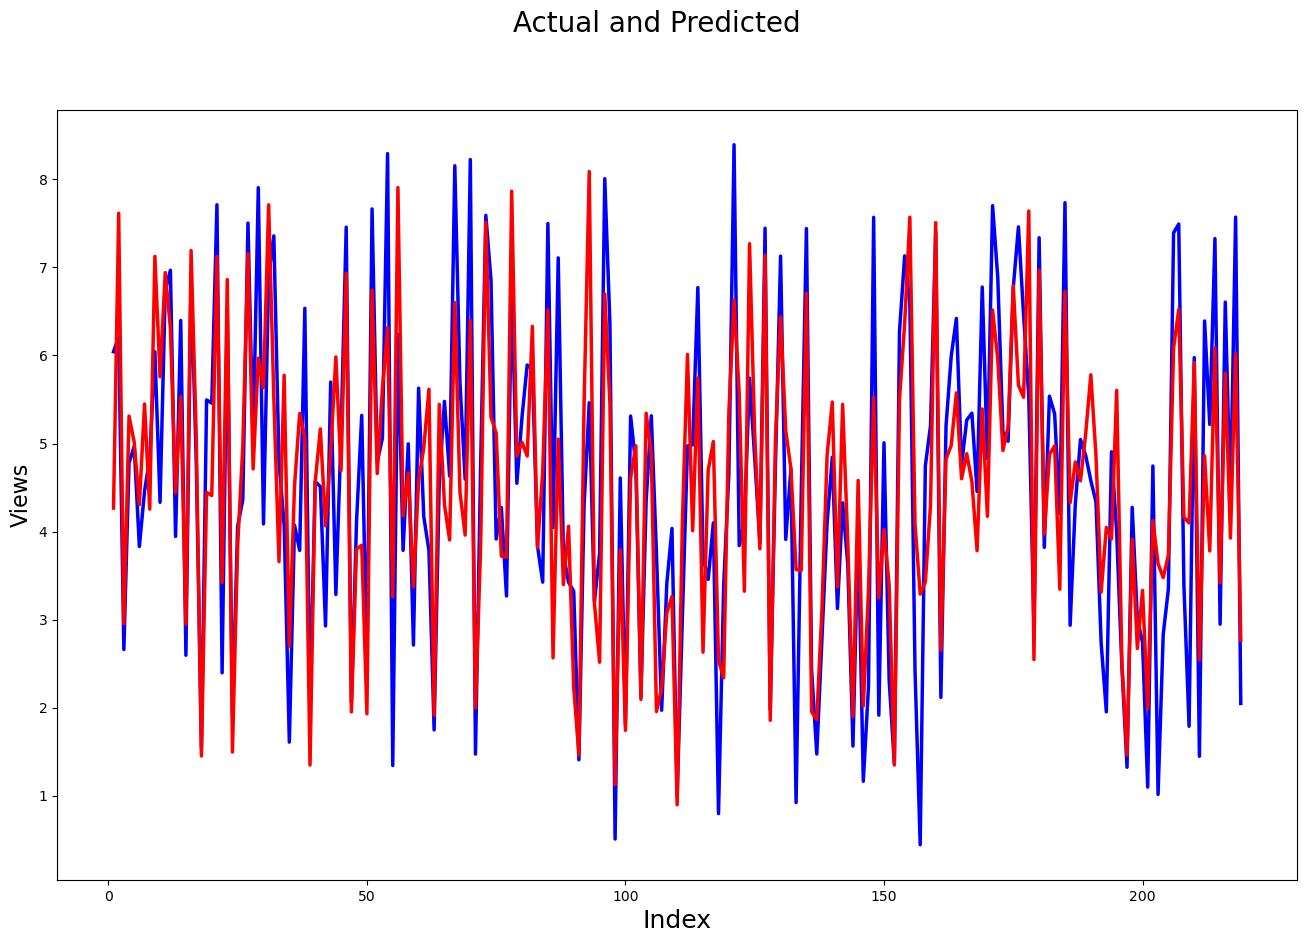

In [53]:
#Actual vs Predicted
c = [i for i in range(1,len(bike_test.cnt_thousand)+1,1)]
fig = plt.figure(figsize = (16, 10))
plt.plot(c,bike_test.cnt_thousand, color="blue", linewidth=2.5, linestyle="-")
plt.plot(c,y_pred_m8, color="red",  linewidth=2.5, linestyle="-")
fig.suptitle('Actual and Predicted', fontsize=20)             
plt.xlabel('Index', fontsize=18)                              
plt.ylabel('Views', fontsize=16)    
plt.show()

#We can see predicted values are very closely aligning with the actuls

#### Step 5.2 - Use Model - 13 (feature - all features minus temp+clear weather+atemp+-ve coeffs, target - cnt) to assess the test data

In [54]:
#get the columns used in model 13
feature_cols_model13 = ['yr', 'workingday', 
                        'feb', 'mar', 'apr', 'may', 'jun', 
                        'jul', 'aug', 'sep', 'oct', 'nov', 'misty', 'snowy']

#take the same columns that we used in model 8 
X_test_m13 = X_test[feature_cols_model13]

# Adding a constant variable 
X_test_m13 = sm.add_constant(X_test_m13)

#make prediction with the lr8 model
y_pred_m13 = lr13.predict(X_test_m13)

##### Step 5.2.1 - Evaluate the model

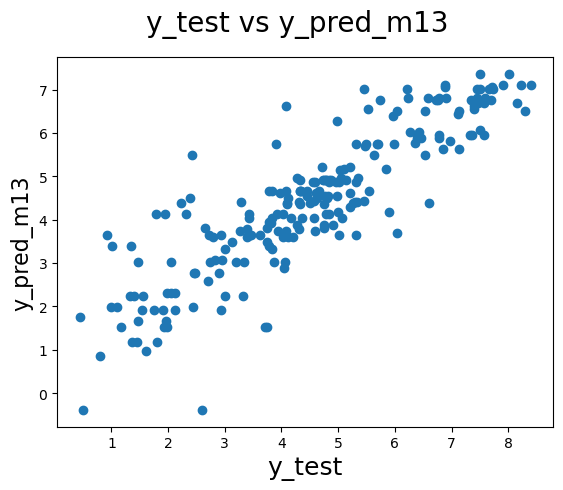

In [55]:
# Plotting y_test and y_pred_m8 to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred_m13)
fig.suptitle('y_test vs y_pred_m13', fontsize=20)              
plt.xlabel('y_test', fontsize=18)                          
plt.ylabel('y_pred_m13', fontsize=16)   
plt.show()

In [56]:
#Check the MSE and r-square scores
mse = mean_squared_error(bike_test['cnt_thousand'], y_pred_m13)
r_squared = r2_score(bike_test['cnt_thousand'], y_pred_m13)

print('Mean_Squared_Error - Model 13:', mse)
print('r_square_value Model 13 :', r_squared)

#We can see the r-squared is very close to what is determined for model 8

Mean_Squared_Error - Model 13: 0.836918844183925
r_square_value Model 13 : 0.7667677351373378


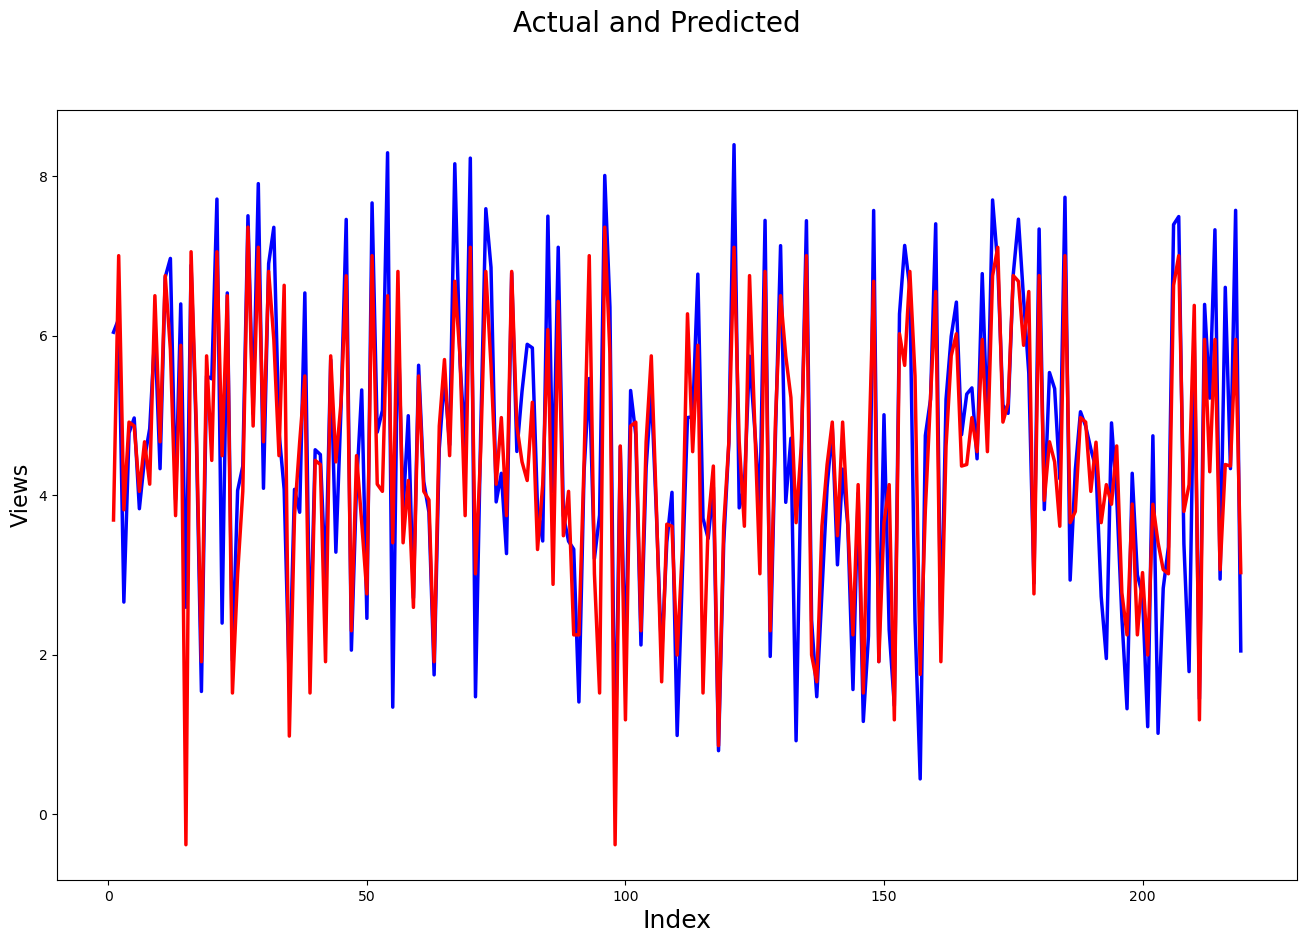

In [57]:
#Actual vs Predicted
c = [i for i in range(1,len(bike_test.cnt_thousand)+1,1)]
fig = plt.figure(figsize = (16, 10))
plt.plot(c,bike_test.cnt_thousand, color="blue", linewidth=2.5, linestyle="-")
plt.plot(c,y_pred_m13, color="red",  linewidth=2.5, linestyle="-")
fig.suptitle('Actual and Predicted', fontsize=20)             
plt.xlabel('Index', fontsize=18)                              
plt.ylabel('Views', fontsize=16)    
plt.show()

#We can see predicted values are very closely aligning with the actuls

#### Step 5.3 - Use Model - 18 (feature - all features with ref support - may - hum - temp feature = true, and target cnt) to assess the test data

In [58]:
#take the same columns that we used in model 18 
X_test_m18 = X_test[feature_cols_model18]

# Adding a constant variable 
X_test_m18 = sm.add_constant(X_test_m18)

#make prediction with the lr18 model
y_pred_m18 = lr18.predict(X_test_m18)

##### Step 5.3.1 - Evaluate the model

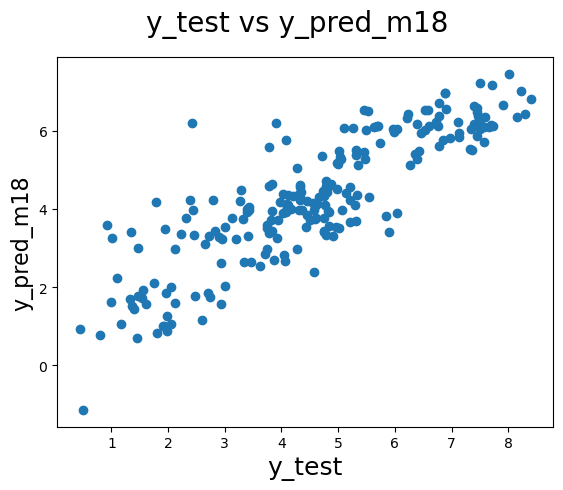

In [59]:
# Plotting y_test and y_pred_m8 to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred_m18)
fig.suptitle('y_test vs y_pred_m18', fontsize=20)              
plt.xlabel('y_test', fontsize=18)                          
plt.ylabel('y_pred_m18', fontsize=16)   
plt.show()

In [60]:
#Check the MSE and r-square scores
mse = mean_squared_error(bike_test['cnt_thousand'], y_pred_m18)
r_squared = r2_score(bike_test['cnt_thousand'], y_pred_m18)

print('Mean_Squared_Error - Model 18:', mse)
print('r_square_value Model 18 :', r_squared)

#We can see the r-squared is very close to what is determined for model 88

Mean_Squared_Error - Model 18: 1.0202888274167714
r_square_value Model 18 : 0.7156662492591845


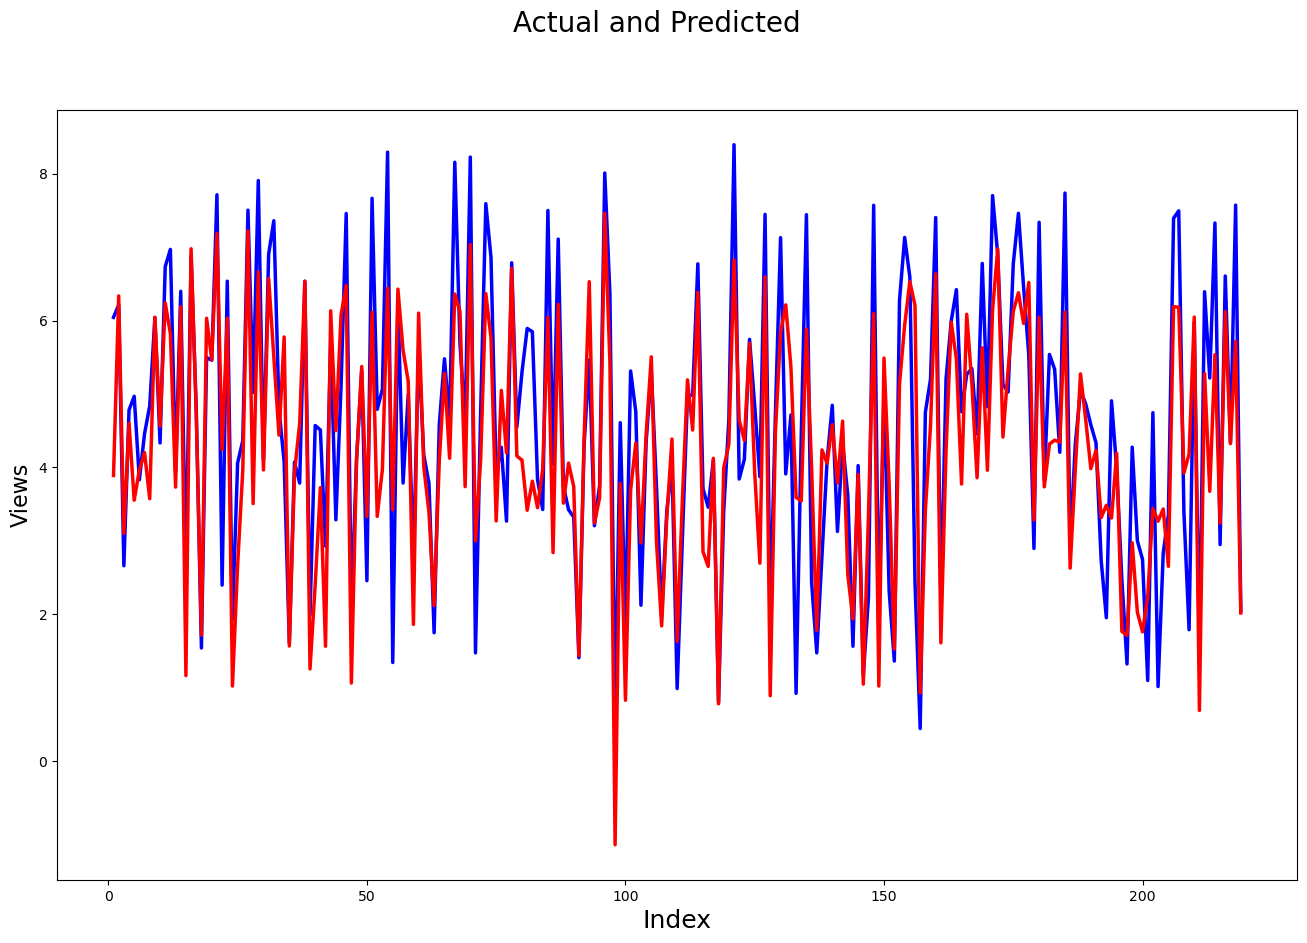

In [61]:
#Actual vs Predicted
c = [i for i in range(1,len(bike_test.cnt_thousand)+1,1)]
fig = plt.figure(figsize = (16, 10))
plt.plot(c,bike_test.cnt_thousand, color="blue", linewidth=2.5, linestyle="-")
plt.plot(c,y_pred_m18, color="red",  linewidth=2.5, linestyle="-")
fig.suptitle('Actual and Predicted', fontsize=20)             
plt.xlabel('Index', fontsize=18)                              
plt.ylabel('Views', fontsize=16)    
plt.show()

#We can see predicted values are very closely aligning with the actuls